# Semester 1 Project Submission - Data Explorers

* Authors: Dylan Orndorf-Ronk, Alex Bonczkiewicz, Alberto Torres, Travis McCloughan, Jaemin Lee

![data explorer](https://media.giphy.com/media/xT9C25UNTwfZuk85WP/giphy-downsized-large.gif)



# Business Understanding

Computing Vision sees all the big companies creating original video content and they want to get in on the fun. They have decided to create a new movie studio, but they don’t have much background in creating movies. You are charged with exploring what types of films are currently doing the best at the box office using different samples of available data. You then will translate those findings into actionable insights that the head of Computing Vision's new movie studio can use to help decide what type of films to create.

## Goals

To provide three concrete business solutions to Computer Vision.

# Data Understanding
   * Source of data
     * [Box Office Mojo](https://www.boxofficemojo.com/)
     * [IMDB](https://www.imdb.com/)
     * [Rotten Tomatoes](https://www.rottentomatoes.com/)
     * [TheMovieDB](https://www.themoviedb.org/)
     * [The Numbers](https://www.the-numbers.com/)
     
   * Description of data & Features used
     * IMDB Data - SQL Database
       * Movie Genres
       * Language
       * Director Names
       * Average Rating
       * Number of Votes
     * The Numbers Data - csv file
       * Production Budget
       * Domestic Gross & Worldwide Gross

## Data Preparation

In [63]:
import sqlite3
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
sns.set_style("darkgrid")

conn = sqlite3.connect('zippedData/im.db')

# use below to supress scientific notation
pd.options.display.float_format = '{:20,.2f}'.format

### Import the IMDB database

The IMDB database includes the tables below

In [64]:
#Selecting table names
q = """
SELECT name 
FROM sqlite_master 
WHERE type='table';
"""
pd.read_sql(q, conn)

,name
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


In [65]:
#Displaying data from movie_basics
movie_basics = pd.read_sql("""
SELECT * 
FROM movie_basics;
""",conn)
movie_basics

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.00,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.00,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.00,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,nan,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.00,"Comedy,Drama,Fantasy"
...,...,...,...,...,...,...
146139,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123.00,Drama
146140,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,nan,Documentary
146141,tt9916706,Dankyavar Danka,Dankyavar Danka,2013,nan,Comedy
146142,tt9916730,6 Gunn,6 Gunn,2017,116.00,None


In [66]:
#Displaying data from movie_ratings
movie_ratings = pd.read_sql("""
SELECT * 
FROM movie_ratings;
""",conn)
movie_ratings

,movie_id,averagerating,numvotes
0,tt10356526,8.30,31
1,tt10384606,8.90,559
2,tt1042974,6.40,20
3,tt1043726,4.20,50352
4,tt1060240,6.50,21
...,...,...,...
73851,tt9805820,8.10,25
73852,tt9844256,7.50,24
73853,tt9851050,4.70,14
73854,tt9886934,7.00,5


In [67]:
#Displaying data from movie_akas
movie_akas = pd.read_sql("""
SELECT * 
FROM movie_akas;
""",conn)
movie_akas

,movie_id,ordering,title,region,language,types,attributes,is_original_title
0,tt0369610,10,Джурасик свят,BG,bg,None,None,0.00
1,tt0369610,11,Jurashikku warudo,JP,None,imdbDisplay,None,0.00
2,tt0369610,12,Jurassic World: O Mundo dos Dinossauros,BR,None,imdbDisplay,None,0.00
3,tt0369610,13,O Mundo dos Dinossauros,BR,None,None,short title,0.00
4,tt0369610,14,Jurassic World,FR,None,imdbDisplay,None,0.00
...,...,...,...,...,...,...,...,...
331698,tt9827784,2,Sayonara kuchibiru,None,None,original,None,1.00
331699,tt9827784,3,Farewell Song,XWW,en,imdbDisplay,None,0.00
331700,tt9880178,1,La atención,None,None,original,None,1.00
331701,tt9880178,2,La atención,ES,None,None,None,0.00


In [68]:
#Displaying all relevant columns from which we will further refine later
#Joined movie_akas to movie_ratings to create one big dataframe
movies_df = pd.read_sql("""
SELECT movie_akas.*, movie_basics.primary_title, movie_basics.original_title,
       movie_basics.start_year, movie_basics.runtime_minutes, movie_basics.genres,
       movie_ratings.averagerating, movie_ratings.numvotes
FROM movie_akas
INNER JOIN
    movie_basics
ON  movie_akas.movie_id = movie_basics.movie_id
INNER JOIN
    movie_ratings
ON  movie_akas.movie_id = movie_ratings.movie_id
""",conn)
movies_df

,movie_id,ordering,title,region,language,types,attributes,is_original_title,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0369610,10,Джурасик свят,BG,bg,None,None,0.00,Jurassic World,Jurassic World,2015,124.00,"Action,Adventure,Sci-Fi",7.00,539338
1,tt0369610,11,Jurashikku warudo,JP,None,imdbDisplay,None,0.00,Jurassic World,Jurassic World,2015,124.00,"Action,Adventure,Sci-Fi",7.00,539338
2,tt0369610,12,Jurassic World: O Mundo dos Dinossauros,BR,None,imdbDisplay,None,0.00,Jurassic World,Jurassic World,2015,124.00,"Action,Adventure,Sci-Fi",7.00,539338
3,tt0369610,13,O Mundo dos Dinossauros,BR,None,None,short title,0.00,Jurassic World,Jurassic World,2015,124.00,"Action,Adventure,Sci-Fi",7.00,539338
4,tt0369610,14,Jurassic World,FR,None,imdbDisplay,None,0.00,Jurassic World,Jurassic World,2015,124.00,"Action,Adventure,Sci-Fi",7.00,539338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261801,tt9726638,2,Monkey King: The Volcano,None,None,original,None,1.00,Monkey King: The Volcano,Monkey King: The Volcano,2019,90.00,"Action,Adventure,Comedy",6.00,6
261802,tt9726638,3,Qi Tian Da Sheng Huo Yan Shan,CN,yue,imdbDisplay,None,0.00,Monkey King: The Volcano,Monkey King: The Volcano,2019,90.00,"Action,Adventure,Comedy",6.00,6
261803,tt9827784,1,Sayonara kuchibiru,JP,None,None,None,0.00,Farewell Song,Sayonara kuchibiru,2019,116.00,"Music,Romance",7.70,6
261804,tt9827784,2,Sayonara kuchibiru,None,None,original,None,1.00,Farewell Song,Sayonara kuchibiru,2019,116.00,"Music,Romance",7.70,6


In [69]:
#Displaying the information for movies_df
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261806 entries, 0 to 261805
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   movie_id           261806 non-null  object 
 1   ordering           261806 non-null  int64  
 2   title              261806 non-null  object 
 3   region             218341 non-null  object 
 4   language           37080 non-null   object 
 5   types              153268 non-null  object 
 6   attributes         12924 non-null   object 
 7   is_original_title  261806 non-null  float64
 8   primary_title      261806 non-null  object 
 9   original_title     261806 non-null  object 
 10  start_year         261806 non-null  int64  
 11  runtime_minutes    250553 non-null  float64
 12  genres             260621 non-null  object 
 13  averagerating      261806 non-null  float64
 14  numvotes           261806 non-null  int64  
dtypes: float64(3), int64(3), object(9)
memory usage: 30

### Data Cleaning & Feature Engineering

Check the rows where genres is null

In [70]:
movies_df[movies_df.genres.isna()]

,movie_id,ordering,title,region,language,types,attributes,is_original_title,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
871,tt1593300,1,Scumrun II,GB,None,None,None,0.00,Scumrun II,Scumrun II,2010,93.00,None,5.10,20
1180,tt1819643,1,Perro muerto,CL,None,None,None,0.00,Perro muerto,Perro muerto,2010,96.00,None,6.70,10
1274,tt1844060,1,The Book,None,None,original,None,1.00,The Book,The Book,2010,nan,None,8.40,5
1275,tt1844060,2,The Book. They Came from Inner Space,US,None,None,complete title,0.00,The Book,The Book,2010,nan,None,8.40,5
1276,tt1844060,3,The Book,US,None,None,None,0.00,The Book,The Book,2010,nan,None,8.40,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259154,tt5833234,1,Carrion,MX,None,None,None,0.00,Carrion,Carrion,2016,73.00,None,5.40,5
259977,tt3322820,1,Piratas y libélulas,ES,None,None,None,0.00,Piratas y libélulas,Piratas y libélulas,2013,72.00,None,8.80,5
261666,tt7293844,1,Los Corroboradores,AR,None,None,None,0.00,Los Corroboradores,Los Corroboradores,2017,70.00,None,7.20,26
261667,tt7293844,2,The Corroborators,XWW,None,festival,None,0.00,Los Corroboradores,Los Corroboradores,2017,70.00,None,7.20,26


We categorize the None genres as "N/A" so there aren't any null values in the genres column

In [71]:
movies_df['genres'] = movies_df['genres'].fillna("N/A")

# Displaying basic information of movies_df dataframe
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261806 entries, 0 to 261805
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   movie_id           261806 non-null  object 
 1   ordering           261806 non-null  int64  
 2   title              261806 non-null  object 
 3   region             218341 non-null  object 
 4   language           37080 non-null   object 
 5   types              153268 non-null  object 
 6   attributes         12924 non-null   object 
 7   is_original_title  261806 non-null  float64
 8   primary_title      261806 non-null  object 
 9   original_title     261806 non-null  object 
 10  start_year         261806 non-null  int64  
 11  runtime_minutes    250553 non-null  float64
 12  genres             261806 non-null  object 
 13  averagerating      261806 non-null  float64
 14  numvotes           261806 non-null  int64  
dtypes: float64(3), int64(3), object(9)
memory usage: 30

### Descriptive Analysis 1 - ROI by Language

In [72]:
movies_genre = movies_df.groupby(['movie_id','genres', 'primary_title','original_title',
                                 'language', 'region']).agg({
                                    'numvotes': 'sum','averagerating': 'mean',
                                    'movie_id': 'count'}).rename(columns={'numvotes': 'num_votes',
                                                             'averagerating': 'avg_rating',
                                                             'movie_id':'num_movies_in_genre'})
movies_genre.head()

num_votes  \
movie_id  genres               primary_title                   original_title        language region              
tt0063540 Action,Crime,Drama   Sunghursh                       Sunghursh             hi       IN            231   
tt0066787 Biography,Drama      One Day Before the Rainy Season Ashad Ka Ek Din       en       XWW            43   
tt0069204 Comedy,Drama         Sabse Bada Sukh                 Sabse Bada Sukh       bn       IN             13   
                                                                                     en       IN             13   
tt0100275 Comedy,Drama,Fantasy The Wandering Soap Opera        La Telenovela Errante en       XWW           119   

                                                                                                               avg_rating  \
movie_id  genres               primary_title                   original_title        language region                        
tt0063540 Action,Crime,Drama   Sunghursh                       Sunghursh             hi       IN                     7.00   
tt0066787 Biography,Drama      One Day Before the Rainy Season Ashad Ka Ek Din       en       XWW                    7.20   
tt0069204 Comedy,Drama         Sabse Bada Sukh                 Sabse Bada Sukh       bn       IN                     6.10   
                                                                                     en       IN                     6.10   
tt0100275 Comedy,Drama,Fantasy The Wandering Soap Opera        La Telenovela Errante en       XWW                    6.50   

                                                                                                      num_movies_in_genre  
movie_id  genres               primary_title                   original_title        language region                       
tt0063540 Action,Crime,Drama   Sunghursh                       Sunghursh             hi       IN                        3  
tt0066787 Biography,Drama      One Day Before the Rainy Season Ashad Ka Ek Din       en       XWW                       1  
tt0069204 Comedy,Drama         Sabse Bada Sukh                 Sabse Bada Sukh       bn       IN                        1  
                                                                                     en       IN                        1  
tt0100275 Comedy,Drama,Fantasy The Wandering Soap Opera        La Telenovela Errante en       XWW                       1

Turn the index genres into a column

In [73]:
movies_genre.reset_index(inplace=True)
movies_genre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35124 entries, 0 to 35123
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   movie_id             35124 non-null  object 
 1   genres               35124 non-null  object 
 2   primary_title        35124 non-null  object 
 3   original_title       35124 non-null  object 
 4   language             35124 non-null  object 
 5   region               35124 non-null  object 
 6   num_votes            35124 non-null  int64  
 7   avg_rating           35124 non-null  float64
 8   num_movies_in_genre  35124 non-null  int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 2.4+ MB


Create a index column for the unique id column

In [74]:
movies_genre.reset_index(inplace=True)
movies_genre.head()

,index,movie_id,genres,primary_title,original_title,language,region,num_votes,avg_rating,num_movies_in_genre
0,0,tt0063540,"Action,Crime,Drama",Sunghursh,Sunghursh,hi,IN,231,7.00,3
1,1,tt0066787,"Biography,Drama",One Day Before the Rainy Season,Ashad Ka Ek Din,en,XWW,43,7.20,1
2,2,tt0069204,"Comedy,Drama",Sabse Bada Sukh,Sabse Bada Sukh,bn,IN,13,6.10,1
3,3,tt0069204,"Comedy,Drama",Sabse Bada Sukh,Sabse Bada Sukh,en,IN,13,6.10,1
4,4,tt0100275,"Comedy,Drama,Fantasy",The Wandering Soap Opera,La Telenovela Errante,en,XWW,119,6.50,1


Rename the unique id column to a useful name

In [75]:

movies_genre = movies_genre.rename(columns={'index': 'genre_group'})
movies_genre.head()

,genre_group,movie_id,genres,primary_title,original_title,language,region,num_votes,avg_rating,num_movies_in_genre
0,0,tt0063540,"Action,Crime,Drama",Sunghursh,Sunghursh,hi,IN,231,7.00,3
1,1,tt0066787,"Biography,Drama",One Day Before the Rainy Season,Ashad Ka Ek Din,en,XWW,43,7.20,1
2,2,tt0069204,"Comedy,Drama",Sabse Bada Sukh,Sabse Bada Sukh,bn,IN,13,6.10,1
3,3,tt0069204,"Comedy,Drama",Sabse Bada Sukh,Sabse Bada Sukh,en,IN,13,6.10,1
4,4,tt0100275,"Comedy,Drama,Fantasy",The Wandering Soap Opera,La Telenovela Errante,en,XWW,119,6.50,1


Turning comma separated generes into individual rows using *.explode()* to transform each element of a list-like to a row, replicating index values

In [76]:
genres_separated = pd.DataFrame(movies_genre.genres.str.split(","), 
                                index=movies_genre.genre_group).explode("genres")
genres_separated

,genres
genre_group,
0,Action
0,Crime
0,Drama
1,Biography
1,Drama
...,...
35120,Drama
35120,Thriller
35121,Comedy


Join the separated group to the original movie_genre table

In [77]:
movie_genres_regrouped = genres_separated.join(movies_genre, how='inner',
                                              lsuffix="_sep", rsuffix="_original")
movie_genres_regrouped.head()

,genres_sep,genre_group,movie_id,genres_original,primary_title,original_title,language,region,num_votes,avg_rating,num_movies_in_genre
0,Action,0,tt0063540,"Action,Crime,Drama",Sunghursh,Sunghursh,hi,IN,231,7.00,3
0,Crime,0,tt0063540,"Action,Crime,Drama",Sunghursh,Sunghursh,hi,IN,231,7.00,3
0,Drama,0,tt0063540,"Action,Crime,Drama",Sunghursh,Sunghursh,hi,IN,231,7.00,3
1,Biography,1,tt0066787,"Biography,Drama",One Day Before the Rainy Season,Ashad Ka Ek Din,en,XWW,43,7.20,1
1,Drama,1,tt0066787,"Biography,Drama",One Day Before the Rainy Season,Ashad Ka Ek Din,en,XWW,43,7.20,1


Get the number of genres for each row 

In [78]:
movie_genres_regrouped['num_genres'] = movie_genres_regrouped['genres_original'].map(lambda x: 
                                                                                     len(x.split(',')))
movie_genres_regrouped.head(10)

,genres_sep,genre_group,movie_id,genres_original,primary_title,original_title,language,region,num_votes,avg_rating,num_movies_in_genre,num_genres
0,Action,0,tt0063540,"Action,Crime,Drama",Sunghursh,Sunghursh,hi,IN,231,7.00,3,3
0,Crime,0,tt0063540,"Action,Crime,Drama",Sunghursh,Sunghursh,hi,IN,231,7.00,3,3
0,Drama,0,tt0063540,"Action,Crime,Drama",Sunghursh,Sunghursh,hi,IN,231,7.00,3,3
1,Biography,1,tt0066787,"Biography,Drama",One Day Before the Rainy Season,Ashad Ka Ek Din,en,XWW,43,7.20,1,2
1,Drama,1,tt0066787,"Biography,Drama",One Day Before the Rainy Season,Ashad Ka Ek Din,en,XWW,43,7.20,1,2
2,Comedy,2,tt0069204,"Comedy,Drama",Sabse Bada Sukh,Sabse Bada Sukh,bn,IN,13,6.10,1,2
2,Drama,2,tt0069204,"Comedy,Drama",Sabse Bada Sukh,Sabse Bada Sukh,bn,IN,13,6.10,1,2
3,Comedy,3,tt0069204,"Comedy,Drama",Sabse Bada Sukh,Sabse Bada Sukh,en,IN,13,6.10,1,2
3,Drama,3,tt0069204,"Comedy,Drama",Sabse Bada Sukh,Sabse Bada Sukh,en,IN,13,6.10,1,2
4,Comedy,4,tt0100275,"Comedy,Drama,Fantasy",The Wandering Soap Opera,La Telenovela Errante,en,XWW,119,6.50,1,3


Import the movie budgets dataset which includes useful metrics such as production_budget, domestic_gross, and worldwide_gross

In [79]:
movie_budgets = pd.read_csv("zippedData/tn.movie_budgets.csv.gz")
movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


Remove multiple special characters i.e. $, "," at once and convert the amounts to float for our analysis

In [80]:
movie_budgets.production_budget = movie_budgets.production_budget.str.replace(r'[<$,]',
                                                                          '', regex=True).astype(float)
movie_budgets.domestic_gross = movie_budgets.domestic_gross.str.replace(r'[<$,]',
                                                                          '', regex=True).astype(float)
movie_budgets.worldwide_gross = movie_budgets.worldwide_gross.str.replace(r'[<$,]',
                                                                          '', regex=True).astype(float)                                                   
movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5782 non-null   int64  
 1   release_date       5782 non-null   object 
 2   movie              5782 non-null   object 
 3   production_budget  5782 non-null   float64
 4   domestic_gross     5782 non-null   float64
 5   worldwide_gross    5782 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 271.2+ KB


Merge movie_genres_regrouped with movie_budgets

In [81]:
movie_genres_budget = movie_genres_regrouped.merge(movie_budgets, left_on="primary_title", 
                                                   right_on="movie")
movie_genres_budget

,genres_sep,genre_group,movie_id,genres_original,primary_title,original_title,language,region,num_votes,avg_rating,num_movies_in_genre,num_genres,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,Adventure,20,tt0337692,"Adventure,Drama,Romance",On the Road,On the Road,bg,BG,37886,6.10,1,3,17,"Mar 22, 2013",On the Road,"25,000,000.00","720,828.00","9,313,302.00"
1,Drama,20,tt0337692,"Adventure,Drama,Romance",On the Road,On the Road,bg,BG,37886,6.10,1,3,17,"Mar 22, 2013",On the Road,"25,000,000.00","720,828.00","9,313,302.00"
2,Romance,20,tt0337692,"Adventure,Drama,Romance",On the Road,On the Road,bg,BG,37886,6.10,1,3,17,"Mar 22, 2013",On the Road,"25,000,000.00","720,828.00","9,313,302.00"
3,Adventure,21,tt0337692,"Adventure,Drama,Romance",On the Road,On the Road,fr,CA,37886,6.10,1,3,17,"Mar 22, 2013",On the Road,"25,000,000.00","720,828.00","9,313,302.00"
4,Drama,21,tt0337692,"Adventure,Drama,Romance",On the Road,On the Road,fr,CA,37886,6.10,1,3,17,"Mar 22, 2013",On the Road,"25,000,000.00","720,828.00","9,313,302.00"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17909,Drama,34660,tt8941440,"Drama,Thriller",Virus,Virus,hi,IN,372,8.60,1,2,69,"Jan 15, 1999",Virus,"75,000,000.00","14,010,690.00","30,626,690.00"
17910,Thriller,34660,tt8941440,"Drama,Thriller",Virus,Virus,hi,IN,372,8.60,1,2,69,"Jan 15, 1999",Virus,"75,000,000.00","14,010,690.00","30,626,690.00"
17911,Documentary,34683,tt8976472,"Documentary,Music",Never Again,Ei koskaan enää,en,XWW,27,6.60,1,2,47,"Jul 12, 2002",Never Again,"500,000.00","307,631.00","308,793.00"
17912,Music,34683,tt8976472,"Documentary,Music",Never Again,Ei koskaan enää,en,XWW,27,6.60,1,2,47,"Jul 12, 2002",Never Again,"500,000.00","307,631.00","308,793.00"


Divide each amount by the number of genres and create separate columns

In [82]:
movie_genres_budget['prod_budget_per_genre'] = movie_genres_budget.production_budget / movie_genres_budget.num_genres
movie_genres_budget['dom_gross_per_genre'] = movie_genres_budget.domestic_gross / movie_genres_budget.num_genres
movie_genres_budget['world_gross_per_genre'] = movie_genres_budget.worldwide_gross / movie_genres_budget.num_genres

#Add domestic and worldwide gross to calculate total gross per genre
movie_genres_budget['tot_gross_per_genre'] = movie_genres_budget.dom_gross_per_genre + movie_genres_budget.world_gross_per_genre
movie_genres_budget.head()

,genres_sep,genre_group,movie_id,genres_original,primary_title,original_title,language,region,num_votes,avg_rating,...,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,prod_budget_per_genre,dom_gross_per_genre,world_gross_per_genre,tot_gross_per_genre
0,Adventure,20,tt0337692,"Adventure,Drama,Romance",On the Road,On the Road,bg,BG,37886,6.10,...,17,"Mar 22, 2013",On the Road,"25,000,000.00","720,828.00","9,313,302.00","8,333,333.33","240,276.00","3,104,434.00","3,344,710.00"
1,Drama,20,tt0337692,"Adventure,Drama,Romance",On the Road,On the Road,bg,BG,37886,6.10,...,17,"Mar 22, 2013",On the Road,"25,000,000.00","720,828.00","9,313,302.00","8,333,333.33","240,276.00","3,104,434.00","3,344,710.00"
2,Romance,20,tt0337692,"Adventure,Drama,Romance",On the Road,On the Road,bg,BG,37886,6.10,...,17,"Mar 22, 2013",On the Road,"25,000,000.00","720,828.00","9,313,302.00","8,333,333.33","240,276.00","3,104,434.00","3,344,710.00"
3,Adventure,21,tt0337692,"Adventure,Drama,Romance",On the Road,On the Road,fr,CA,37886,6.10,...,17,"Mar 22, 2013",On the Road,"25,000,000.00","720,828.00","9,313,302.00","8,333,333.33","240,276.00","3,104,434.00","3,344,710.00"
4,Drama,21,tt0337692,"Adventure,Drama,Romance",On the Road,On the Road,fr,CA,37886,6.10,...,17,"Mar 22, 2013",On the Road,"25,000,000.00","720,828.00","9,313,302.00","8,333,333.33","240,276.00","3,104,434.00","3,344,710.00"


Group by genres and sum the total gross per genre

In [83]:
movie_genres_budget.sort_values(['avg_rating'],ascending=False).groupby(['genres_sep']).agg({
                                    'num_votes': 'sum','avg_rating': 'mean',
                                    'tot_gross_per_genre': 'sum'})

,num_votes,avg_rating,tot_gross_per_genre
genres_sep,,,
Action,489895308,6.43,"303,364,652,048.00"
Adventure,465573927,6.55,"364,316,164,815.83"
Animation,85944665,6.76,"113,150,526,801.33"
Biography,77451526,7.07,"29,095,724,063.00"
Comedy,248343110,6.40,"213,439,728,008.17"
Crime,142658551,6.46,"53,539,246,259.83"
Documentary,899240,7.11,"2,978,490,085.67"
Drama,387451948,6.67,"169,098,449,419.00"
Family,53869391,6.22,"59,199,282,701.67"


Merge movie_genres_regrouped with movie_budgets

In [84]:
movie_genres_budget = movie_genres_regrouped.merge(movie_budgets, left_on="primary_title", 
                                                   right_on="movie")
movie_genres_budget['ROI'] = (movie_genres_budget['domestic_gross'] + movie_genres_budget['worldwide_gross']) / movie_genres_budget['production_budget'] * 100
movie_genres_budget

,genres_sep,genre_group,movie_id,genres_original,primary_title,original_title,language,region,num_votes,avg_rating,num_movies_in_genre,num_genres,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,ROI
0,Adventure,20,tt0337692,"Adventure,Drama,Romance",On the Road,On the Road,bg,BG,37886,6.10,1,3,17,"Mar 22, 2013",On the Road,"25,000,000.00","720,828.00","9,313,302.00",40.14
1,Drama,20,tt0337692,"Adventure,Drama,Romance",On the Road,On the Road,bg,BG,37886,6.10,1,3,17,"Mar 22, 2013",On the Road,"25,000,000.00","720,828.00","9,313,302.00",40.14
2,Romance,20,tt0337692,"Adventure,Drama,Romance",On the Road,On the Road,bg,BG,37886,6.10,1,3,17,"Mar 22, 2013",On the Road,"25,000,000.00","720,828.00","9,313,302.00",40.14
3,Adventure,21,tt0337692,"Adventure,Drama,Romance",On the Road,On the Road,fr,CA,37886,6.10,1,3,17,"Mar 22, 2013",On the Road,"25,000,000.00","720,828.00","9,313,302.00",40.14
4,Drama,21,tt0337692,"Adventure,Drama,Romance",On the Road,On the Road,fr,CA,37886,6.10,1,3,17,"Mar 22, 2013",On the Road,"25,000,000.00","720,828.00","9,313,302.00",40.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17909,Drama,34660,tt8941440,"Drama,Thriller",Virus,Virus,hi,IN,372,8.60,1,2,69,"Jan 15, 1999",Virus,"75,000,000.00","14,010,690.00","30,626,690.00",59.52
17910,Thriller,34660,tt8941440,"Drama,Thriller",Virus,Virus,hi,IN,372,8.60,1,2,69,"Jan 15, 1999",Virus,"75,000,000.00","14,010,690.00","30,626,690.00",59.52
17911,Documentary,34683,tt8976472,"Documentary,Music",Never Again,Ei koskaan enää,en,XWW,27,6.60,1,2,47,"Jul 12, 2002",Never Again,"500,000.00","307,631.00","308,793.00",123.28
17912,Music,34683,tt8976472,"Documentary,Music",Never Again,Ei koskaan enää,en,XWW,27,6.60,1,2,47,"Jul 12, 2002",Never Again,"500,000.00","307,631.00","308,793.00",123.28


Remove duplications on a copy of the dataframe

In [85]:
movie_budget_dup_removed = movie_genres_budget.copy()
movie_budget_dup_removed = movie_budget_dup_removed.drop_duplicates(subset=['genre_group'], keep='first')

Calculate ROI for our analysis

In [86]:
roi = movie_budget_dup_removed.sort_values(by=['ROI'], ascending=False)

roi_sum = roi.groupby(['primary_title','language']).agg({'production_budget': 'mean','domestic_gross': 'mean',
                                    'worldwide_gross': 'mean',
                                   'ROI': 'mean'})


roi_count = roi_sum.groupby(['primary_title'], sort=False).size().reset_index(name='primary_title_count')
roi_merge = roi.merge(roi_count, left_on="primary_title", 
                                                   right_on="primary_title")

#Roi_merge['budget_by_title'] = roi_merge['production_budget'] / roi_merge['primary_title_count']
roi_merge['dom_gross_title'] = roi_merge['domestic_gross'] / roi_merge['primary_title_count']
roi_merge['WW_gross_title'] = roi_merge['worldwide_gross'] / roi_merge['primary_title_count']
roi_merge['ROI_by_title'] = roi_merge['ROI'] / roi_merge['primary_title_count']
roi_merge

,genres_sep,genre_group,movie_id,genres_original,primary_title,original_title,language,region,num_votes,avg_rating,...,release_date,movie,production_budget,domestic_gross,worldwide_gross,ROI,primary_title_count,dom_gross_title,WW_gross_title,ROI_by_title
0,Horror,13830,tt2309260,"Horror,Mystery,Thriller",The Gallows,The Gallows,fr,CA,17763,4.20,...,"Jul 10, 2015",The Gallows,"100,000.00","22,764,410.00","41,656,474.00","64,420.88",2,"11,382,205.00","20,828,237.00","32,210.44"
1,Horror,13831,tt2309260,"Horror,Mystery,Thriller",The Gallows,The Gallows,tr,TR,17763,4.20,...,"Jul 10, 2015",The Gallows,"100,000.00","22,764,410.00","41,656,474.00","64,420.88",2,"11,382,205.00","20,828,237.00","32,210.44"
2,Horror,4580,tt1560985,Horror,The Devil Inside,The Devil Inside,tr,TR,33522,4.20,...,"Jan 6, 2012",The Devil Inside,"1,000,000.00","53,262,945.00","101,759,490.00","15,502.24",5,"10,652,589.00","20,351,898.00","3,100.45"
3,Horror,4579,tt1560985,Horror,The Devil Inside,The Devil Inside,he,IL,33522,4.20,...,"Jan 6, 2012",The Devil Inside,"1,000,000.00","53,262,945.00","101,759,490.00","15,502.24",5,"10,652,589.00","20,351,898.00","3,100.45"
4,Horror,4578,tt1560985,Horror,The Devil Inside,The Devil Inside,fr,CA,33522,4.20,...,"Jan 6, 2012",The Devil Inside,"1,000,000.00","53,262,945.00","101,759,490.00","15,502.24",5,"10,652,589.00","20,351,898.00","3,100.45"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6534,Drama,8000,tt1781935,"Drama,Horror,Thriller",The Ridges,The Ridges,es,US,127,2.90,...,"Nov 25, 2011",The Ridges,"17,300.00",0.00,0.00,0.00,1,0.00,0.00,0.00
6535,Drama,8001,tt1781935,"Drama,Horror,Thriller",The Ridges,The Ridges,es,XWW,127,2.90,...,"Nov 25, 2011",The Ridges,"17,300.00",0.00,0.00,0.00,1,0.00,0.00,0.00
6536,Drama,11310,tt2073661,"Drama,Thriller",Dawn Patrol,Stranded,en,XWW,615,4.80,...,"Jun 5, 2015",Dawn Patrol,"3,500,000.00",0.00,0.00,0.00,1,0.00,0.00,0.00
6537,Drama,11309,tt2073661,"Drama,Thriller",Dawn Patrol,Stranded,en,US,615,4.80,...,"Jun 5, 2015",Dawn Patrol,"3,500,000.00",0.00,0.00,0.00,1,0.00,0.00,0.00


In [87]:
# check numeric values of the data
roi_merge.describe()

,genre_group,num_votes,avg_rating,num_movies_in_genre,num_genres,id,production_budget,domestic_gross,worldwide_gross,ROI,primary_title_count,dom_gross_title,WW_gross_title,ROI_by_title
count,"6,539.00","6,539.00","6,539.00","6,539.00","6,539.00","6,539.00","6,539.00","6,539.00","6,539.00","6,539.00","6,539.00","6,539.00","6,539.00","6,539.00"
mean,"11,025.25","150,202.32",6.48,1.02,2.62,50.82,"57,200,682.92","74,481,226.63","193,677,888.80",616.09,4.52,"15,333,330.34","38,419,557.69",156.05
std,"9,223.29","199,913.96",0.96,0.14,0.63,28.24,"62,857,498.05","99,465,552.99","280,772,142.22","1,491.95",2.07,"20,631,243.10","59,887,048.70",618.97
min,20.00,5.00,1.60,1.00,1.00,1.00,"7,000.00",0.00,0.00,0.00,1.00,0.00,0.00,0.00
25%,"2,842.50","30,828.00",5.90,1.00,2.00,27.00,"13,000,000.00","12,008,642.00","24,555,177.00",174.14,4.00,"3,159,824.25","6,829,468.00",41.64
50%,"8,715.00","82,237.00",6.50,1.00,3.00,51.00,"33,000,000.00","39,282,227.00","82,182,803.00",362.89,4.00,"9,122,776.43","19,284,059.00",79.78
75%,"17,644.50","191,494.00",7.20,1.00,3.00,75.00,"79,000,000.00","94,835,059.00","229,008,658.00",642.15,5.00,"20,876,004.25","49,060,701.00",147.57
max,"35,121.00","1,841,066.00",8.80,4.00,3.00,100.00,"425,000,000.00","760,507,625.00","2,776,345,279.00","64,420.88",22.00,"760,507,625.00","2,776,345,279.00","32,210.44"


Subset the entire dataset to where ROI is greater than 80% and it's less than 200% to exclude outliers.

In [88]:
roi_merge_subset = roi_merge[(roi_merge['ROI_by_title']>80) & (roi_merge['ROI_by_title']<200) & (roi_merge['ROI_by_title']!=0)]
roi_merge_subset.describe()

,genre_group,num_votes,avg_rating,num_movies_in_genre,num_genres,id,production_budget,domestic_gross,worldwide_gross,ROI,primary_title_count,dom_gross_title,WW_gross_title,ROI_by_title
count,"2,130.00","2,130.00","2,130.00","2,130.00","2,130.00","2,130.00","2,130.00","2,130.00","2,130.00","2,130.00","2,130.00","2,130.00","2,130.00","2,130.00"
mean,"10,629.25","215,464.61",6.73,1.01,2.62,52.50,"68,858,079.81","114,593,297.16","305,549,989.94",561.77,4.60,"22,582,833.38","58,590,520.93",122.59
std,"8,941.85","251,531.33",0.90,0.13,0.64,28.68,"64,035,069.70","123,502,877.66","357,200,936.48",226.12,1.47,"20,349,137.95","59,019,369.54",31.57
min,50.00,5.00,2.60,1.00,1.00,1.00,"70,000.00","30,312.00","30,312.00",83.82,1.00,"30,312.00","30,312.00",80.20
25%,"2,632.25","51,538.00",6.20,1.00,2.00,28.00,"20,000,000.00","34,659,605.00","63,288,854.00",402.31,4.00,"8,471,840.80","15,685,654.83",95.97
50%,"8,845.50","123,107.00",6.80,1.00,3.00,52.00,"40,000,000.00","63,859,435.00","153,986,624.00",535.34,5.00,"15,288,381.50","33,177,823.40",115.78
75%,"16,774.25","300,301.25",7.40,1.00,3.00,77.00,"110,000,000.00","162,652,305.50","454,680,985.00",682.20,5.00,"33,220,088.59","92,642,444.00",146.54
max,"35,121.00","1,841,066.00",8.80,3.00,3.00,100.00,"330,600,000.00","678,815,482.00","2,048,134,200.00","1,357.42",9.00,"113,135,913.67","341,355,700.00",199.69


Bar plot to show that data has extreme outliers without the ROI filter.

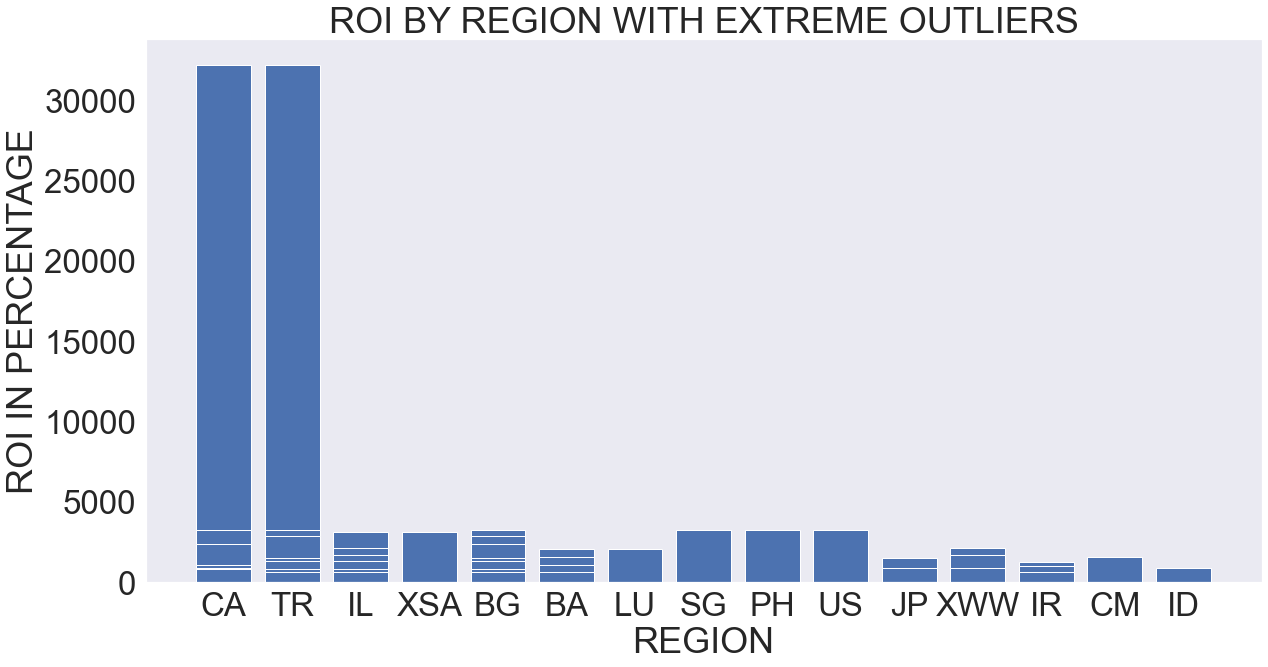

In [89]:
#ROI By Region WITH Extreme Outliers showing top 100
roi_merge_top_100 = roi_merge[0:100]

roi_merge_top_100
fig, ax = plt.subplots(figsize=(20,10))
ax.grid(False)
plt.bar(roi_merge_top_100['region'], roi_merge_top_100['ROI_by_title'])
plt.title('ROI BY REGION WITH EXTREME OUTLIERS')
plt.xlabel('REGION')
plt.ylabel('ROI IN PERCENTAGE')
plt.show()

In [90]:
roi_merge_subset_sorted = roi_merge_subset.sort_values(by='ROI_by_title', ascending=False)
roi_merge_subset_sorted

,genres_sep,genre_group,movie_id,genres_original,primary_title,original_title,language,region,num_votes,avg_rating,...,release_date,movie,production_budget,domestic_gross,worldwide_gross,ROI,primary_title_count,dom_gross_title,WW_gross_title,ROI_by_title
1821,Comedy,1833,tt1229340,Comedy,Anchorman 2: The Legend Continues,Anchorman 2: The Legend Continues,tr,TR,156116,6.30,...,"Dec 18, 2013",Anchorman 2: The Legend Continues,"50,000,000.00","127,352,707.00","172,185,754.00",599.08,3,"42,450,902.33","57,395,251.33",199.69
1822,Comedy,1831,tt1229340,Comedy,Anchorman 2: The Legend Continues,Anchorman 2: The Legend Continues,fr,CA,156116,6.30,...,"Dec 18, 2013",Anchorman 2: The Legend Continues,"50,000,000.00","127,352,707.00","172,185,754.00",599.08,3,"42,450,902.33","57,395,251.33",199.69
1823,Comedy,1832,tt1229340,Comedy,Anchorman 2: The Legend Continues,Anchorman 2: The Legend Continues,he,IL,156116,6.30,...,"Dec 18, 2013",Anchorman 2: The Legend Continues,"50,000,000.00","127,352,707.00","172,185,754.00",599.08,3,"42,450,902.33","57,395,251.33",199.69
865,Action,10102,tt1951264,"Action,Adventure,Sci-Fi",The Hunger Games: Catching Fire,The Hunger Games: Catching Fire,en,CA,575455,7.50,...,"Nov 22, 2013",The Hunger Games: Catching Fire,"130,000,000.00","424,668,047.00","864,868,047.00",991.95,5,"84,933,609.40","172,973,609.40",198.39
862,Action,10105,tt1951264,"Action,Adventure,Sci-Fi",The Hunger Games: Catching Fire,The Hunger Games: Catching Fire,tr,TR,575455,7.50,...,"Nov 22, 2013",The Hunger Games: Catching Fire,"130,000,000.00","424,668,047.00","864,868,047.00",991.95,5,"84,933,609.40","172,973,609.40",198.39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2913,Comedy,12316,tt2170439,"Comedy,Crime",Horrible Bosses 2,Horrible Bosses 2,bg,BG,144442,6.30,...,"Nov 26, 2014",Horrible Bosses 2,"40,000,000.00","54,445,357.00","105,945,357.00",400.98,5,"10,889,071.40","21,189,071.40",80.20
2914,Comedy,12320,tt2170439,"Comedy,Crime",Horrible Bosses 2,Horrible Bosses 2,tr,TR,144442,6.30,...,"Nov 26, 2014",Horrible Bosses 2,"40,000,000.00","54,445,357.00","105,945,357.00",400.98,5,"10,889,071.40","21,189,071.40",80.20
2915,Comedy,12318,tt2170439,"Comedy,Crime",Horrible Bosses 2,Horrible Bosses 2,fr,CA,144442,6.30,...,"Nov 26, 2014",Horrible Bosses 2,"40,000,000.00","54,445,357.00","105,945,357.00",400.98,5,"10,889,071.40","21,189,071.40",80.20
2916,Comedy,12319,tt2170439,"Comedy,Crime",Horrible Bosses 2,Horrible Bosses 2,he,IL,144442,6.30,...,"Nov 26, 2014",Horrible Bosses 2,"40,000,000.00","54,445,357.00","105,945,357.00",400.98,5,"10,889,071.40","21,189,071.40",80.20


ROI by all languages.

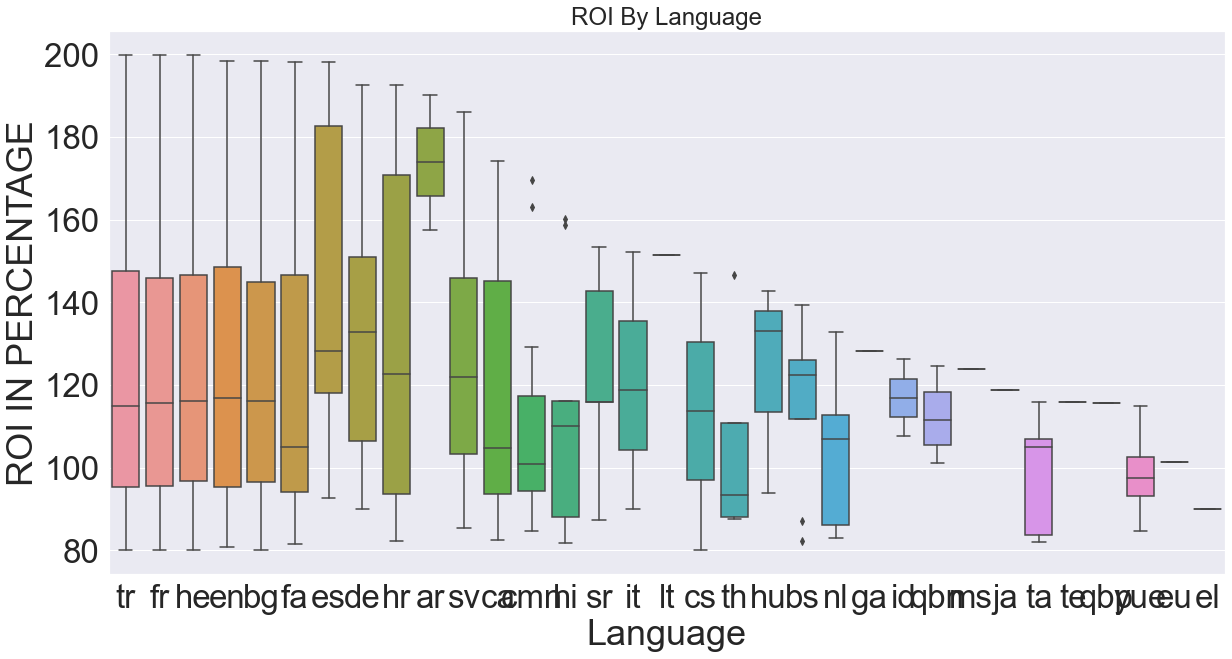

In [91]:
fig, ax = plt.subplots(figsize=(20, 10))
ax = sns.boxplot(ax=ax, data=roi_merge_subset_sorted, x='language', 
                 y='ROI_by_title')
sns.set(font_scale=2)
ax.set(xlabel='Language', ylabel='ROI IN PERCENTAGE', title='ROI By Language');

Filtering to top 7 languages by ROI.

In [92]:
roi_merge_subset_sorted_top7 = roi_merge_subset_sorted[(roi_merge_subset_sorted.language == "tr") |
                       (roi_merge_subset_sorted.language == "fr") |
                       (roi_merge_subset_sorted.language == "he") |
                       (roi_merge_subset_sorted.language == "en") |
                       (roi_merge_subset_sorted.language == "bg") |
                       (roi_merge_subset_sorted.language == "fa") |
                       (roi_merge_subset_sorted.language == "es")]
roi_merge_subset_sorted_top7

,genres_sep,genre_group,movie_id,genres_original,primary_title,original_title,language,region,num_votes,avg_rating,...,release_date,movie,production_budget,domestic_gross,worldwide_gross,ROI,primary_title_count,dom_gross_title,WW_gross_title,ROI_by_title
1821,Comedy,1833,tt1229340,Comedy,Anchorman 2: The Legend Continues,Anchorman 2: The Legend Continues,tr,TR,156116,6.30,...,"Dec 18, 2013",Anchorman 2: The Legend Continues,"50,000,000.00","127,352,707.00","172,185,754.00",599.08,3,"42,450,902.33","57,395,251.33",199.69
1822,Comedy,1831,tt1229340,Comedy,Anchorman 2: The Legend Continues,Anchorman 2: The Legend Continues,fr,CA,156116,6.30,...,"Dec 18, 2013",Anchorman 2: The Legend Continues,"50,000,000.00","127,352,707.00","172,185,754.00",599.08,3,"42,450,902.33","57,395,251.33",199.69
1823,Comedy,1832,tt1229340,Comedy,Anchorman 2: The Legend Continues,Anchorman 2: The Legend Continues,he,IL,156116,6.30,...,"Dec 18, 2013",Anchorman 2: The Legend Continues,"50,000,000.00","127,352,707.00","172,185,754.00",599.08,3,"42,450,902.33","57,395,251.33",199.69
865,Action,10102,tt1951264,"Action,Adventure,Sci-Fi",The Hunger Games: Catching Fire,The Hunger Games: Catching Fire,en,CA,575455,7.50,...,"Nov 22, 2013",The Hunger Games: Catching Fire,"130,000,000.00","424,668,047.00","864,868,047.00",991.95,5,"84,933,609.40","172,973,609.40",198.39
862,Action,10105,tt1951264,"Action,Adventure,Sci-Fi",The Hunger Games: Catching Fire,The Hunger Games: Catching Fire,tr,TR,575455,7.50,...,"Nov 22, 2013",The Hunger Games: Catching Fire,"130,000,000.00","424,668,047.00","864,868,047.00",991.95,5,"84,933,609.40","172,973,609.40",198.39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3606,Comedy,1651,tt1212436,"Comedy,Romance",The Back-up Plan,The Back-up Plan,he,IL,46128,5.40,...,"Apr 23, 2010",The Back-up Plan,"35,000,000.00","37,490,007.00","75,281,179.00",322.20,4,"9,372,501.75","18,820,294.75",80.55
2913,Comedy,12316,tt2170439,"Comedy,Crime",Horrible Bosses 2,Horrible Bosses 2,bg,BG,144442,6.30,...,"Nov 26, 2014",Horrible Bosses 2,"40,000,000.00","54,445,357.00","105,945,357.00",400.98,5,"10,889,071.40","21,189,071.40",80.20
2914,Comedy,12320,tt2170439,"Comedy,Crime",Horrible Bosses 2,Horrible Bosses 2,tr,TR,144442,6.30,...,"Nov 26, 2014",Horrible Bosses 2,"40,000,000.00","54,445,357.00","105,945,357.00",400.98,5,"10,889,071.40","21,189,071.40",80.20
2915,Comedy,12318,tt2170439,"Comedy,Crime",Horrible Bosses 2,Horrible Bosses 2,fr,CA,144442,6.30,...,"Nov 26, 2014",Horrible Bosses 2,"40,000,000.00","54,445,357.00","105,945,357.00",400.98,5,"10,889,071.40","21,189,071.40",80.20


Boxplot of ROI by top 7 languages.

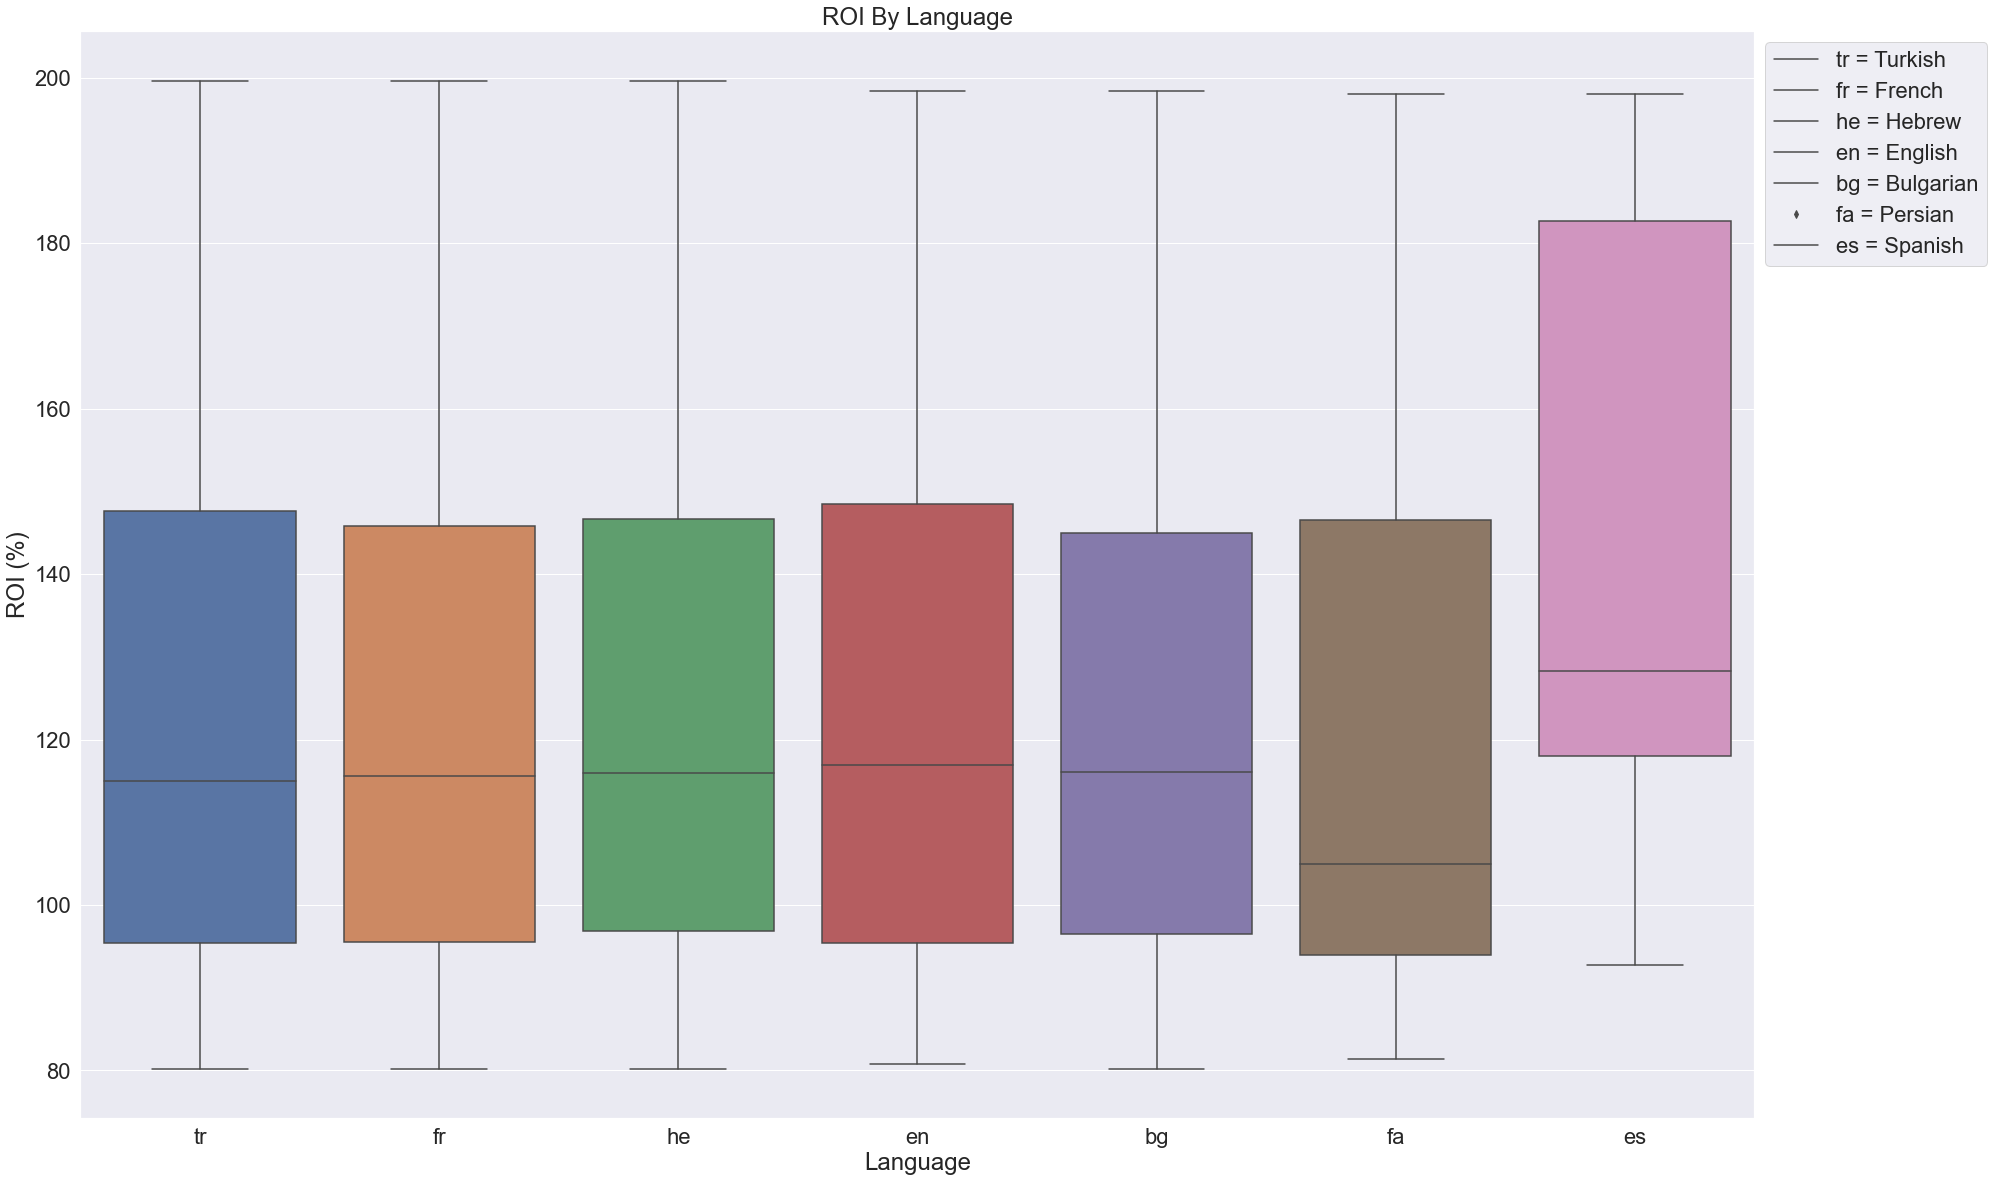

In [93]:
fig, ax = plt.subplots(figsize=(30, 20))
ax = sns.boxplot(ax=ax, data=roi_merge_subset_sorted_top7, x='language', 
                 y='ROI_by_title')
ax.legend(['tr = Turkish', "fr = French", "he = Hebrew", "en = English" ,"bg = Bulgarian",
           "fa = Persian", "es = Spanish"], bbox_to_anchor=(1,1))
ax.set(xlabel='Language', ylabel='ROI (%)', title='ROI By Language')
sns.set(font_scale=4);

### Descriptive Analysis 2: Famous Directors

In [94]:
persons = pd.read_sql("""
SELECT *
FROM persons;
""", conn)
persons

,person_id,primary_name,birth_year,death_year,primary_profession
0,nm0061671,Mary Ellen Bauder,nan,nan,"miscellaneous,production_manager,producer"
1,nm0061865,Joseph Bauer,nan,nan,"composer,music_department,sound_department"
2,nm0062070,Bruce Baum,nan,nan,"miscellaneous,actor,writer"
3,nm0062195,Axel Baumann,nan,nan,"camera_department,cinematographer,art_department"
4,nm0062798,Pete Baxter,nan,nan,"production_designer,art_department,set_decorator"
...,...,...,...,...,...
606643,nm9990381,Susan Grobes,nan,nan,actress
606644,nm9990690,Joo Yeon So,nan,nan,actress
606645,nm9991320,Madeline Smith,nan,nan,actress
606646,nm9991786,Michelle Modigliani,nan,nan,producer


In [95]:
directors = pd.read_sql("""
SELECT *
FROM directors;
""", conn)
directors

,movie_id,person_id
0,tt0285252,nm0899854
1,tt0462036,nm1940585
2,tt0835418,nm0151540
3,tt0835418,nm0151540
4,tt0878654,nm0089502
...,...,...
291169,tt8999974,nm10122357
291170,tt9001390,nm6711477
291171,tt9001494,nm10123242
291172,tt9001494,nm10123248


In [96]:
movie_ratings = pd.read_sql("""
SELECT *
FROM movie_ratings
ORDER BY numvotes DESC;
""", conn)
movie_ratings

,movie_id,averagerating,numvotes
0,tt1375666,8.80,1841066
1,tt1345836,8.40,1387769
2,tt0816692,8.60,1299334
3,tt1853728,8.40,1211405
4,tt0848228,8.10,1183655
...,...,...,...
73851,tt8420530,6.80,5
73852,tt8747790,4.60,5
73853,tt9367004,8.20,5
73854,tt9647642,2.00,5


Join directors, persons, and ratings

In [97]:
directors_df = pd.read_sql("""
SELECT p.primary_name, r.averagerating, r.numvotes
FROM persons p
INNER JOIN
    directors d
ON  p.person_id = d.person_id
INNER JOIN
    movie_ratings r
ON  d.movie_id = r.movie_id
WHERE r.numvotes > 750000
GROUP BY p.primary_name
ORDER BY r.averagerating DESC
""", conn)
directors_df

,primary_name,averagerating,numvotes
0,Quentin Tarantino,8.40,1211405
1,Christopher Nolan,8.40,1387769
2,Martin Scorsese,8.10,1005960
3,Joss Whedon,8.10,1183655
4,James Gunn,8.10,948394
5,George Miller,8.10,780910
6,David Fincher,8.10,761592
7,Tim Miller,8.00,820847
8,J.J. Abrams,8.00,784780
9,Gary Ross,7.20,795227


Bar plot to represent directors' average ratings with highest number of votes

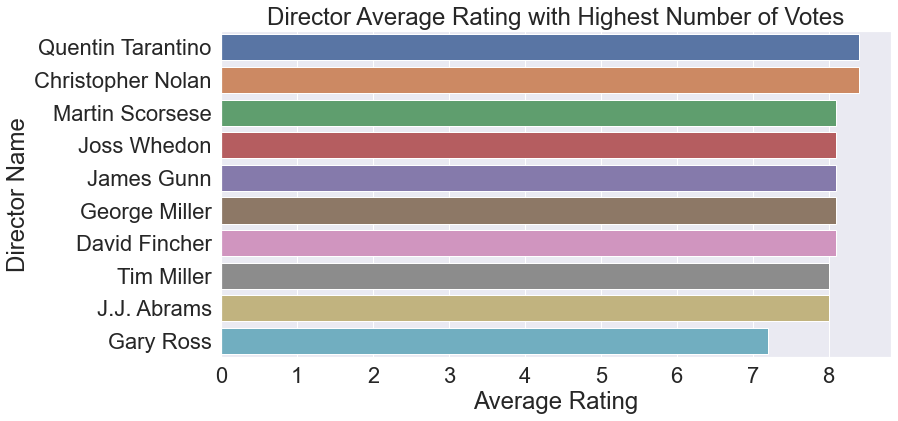

In [117]:
fig, ax = plt.subplots(figsize=(12,6))
sns.set(font_scale=2)
ax = sns.barplot(x='averagerating', y='primary_name', data=directors_df)
ax.set(xlabel='Average Rating', 
       ylabel='Director Name', 
       title='Director Average Rating with Highest Number of Votes');

In [99]:
# merge movie_genres_regrouped with movie_budgets
movie_genres_budget = movie_genres_regrouped.merge(movie_budgets, left_on="primary_title", 
                                                   right_on="movie")
movie_genres_budget

,genres_sep,genre_group,movie_id,genres_original,primary_title,original_title,language,region,num_votes,avg_rating,num_movies_in_genre,num_genres,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,Adventure,20,tt0337692,"Adventure,Drama,Romance",On the Road,On the Road,bg,BG,37886,6.10,1,3,17,"Mar 22, 2013",On the Road,"25,000,000.00","720,828.00","9,313,302.00"
1,Drama,20,tt0337692,"Adventure,Drama,Romance",On the Road,On the Road,bg,BG,37886,6.10,1,3,17,"Mar 22, 2013",On the Road,"25,000,000.00","720,828.00","9,313,302.00"
2,Romance,20,tt0337692,"Adventure,Drama,Romance",On the Road,On the Road,bg,BG,37886,6.10,1,3,17,"Mar 22, 2013",On the Road,"25,000,000.00","720,828.00","9,313,302.00"
3,Adventure,21,tt0337692,"Adventure,Drama,Romance",On the Road,On the Road,fr,CA,37886,6.10,1,3,17,"Mar 22, 2013",On the Road,"25,000,000.00","720,828.00","9,313,302.00"
4,Drama,21,tt0337692,"Adventure,Drama,Romance",On the Road,On the Road,fr,CA,37886,6.10,1,3,17,"Mar 22, 2013",On the Road,"25,000,000.00","720,828.00","9,313,302.00"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17909,Drama,34660,tt8941440,"Drama,Thriller",Virus,Virus,hi,IN,372,8.60,1,2,69,"Jan 15, 1999",Virus,"75,000,000.00","14,010,690.00","30,626,690.00"
17910,Thriller,34660,tt8941440,"Drama,Thriller",Virus,Virus,hi,IN,372,8.60,1,2,69,"Jan 15, 1999",Virus,"75,000,000.00","14,010,690.00","30,626,690.00"
17911,Documentary,34683,tt8976472,"Documentary,Music",Never Again,Ei koskaan enää,en,XWW,27,6.60,1,2,47,"Jul 12, 2002",Never Again,"500,000.00","307,631.00","308,793.00"
17912,Music,34683,tt8976472,"Documentary,Music",Never Again,Ei koskaan enää,en,XWW,27,6.60,1,2,47,"Jul 12, 2002",Never Again,"500,000.00","307,631.00","308,793.00"


In [100]:
# divide each amount by the number of genres and create separate columns
movie_genres_budget['prod_budget_per_genre'] = movie_genres_budget.production_budget / movie_genres_budget.num_genres
movie_genres_budget['dom_gross_per_genre'] = movie_genres_budget.domestic_gross / movie_genres_budget.num_genres
movie_genres_budget['world_gross_per_genre'] = movie_genres_budget.worldwide_gross / movie_genres_budget.num_genres
movie_genres_budget.head()

,genres_sep,genre_group,movie_id,genres_original,primary_title,original_title,language,region,num_votes,avg_rating,...,num_genres,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,prod_budget_per_genre,dom_gross_per_genre,world_gross_per_genre
0,Adventure,20,tt0337692,"Adventure,Drama,Romance",On the Road,On the Road,bg,BG,37886,6.10,...,3,17,"Mar 22, 2013",On the Road,"25,000,000.00","720,828.00","9,313,302.00","8,333,333.33","240,276.00","3,104,434.00"
1,Drama,20,tt0337692,"Adventure,Drama,Romance",On the Road,On the Road,bg,BG,37886,6.10,...,3,17,"Mar 22, 2013",On the Road,"25,000,000.00","720,828.00","9,313,302.00","8,333,333.33","240,276.00","3,104,434.00"
2,Romance,20,tt0337692,"Adventure,Drama,Romance",On the Road,On the Road,bg,BG,37886,6.10,...,3,17,"Mar 22, 2013",On the Road,"25,000,000.00","720,828.00","9,313,302.00","8,333,333.33","240,276.00","3,104,434.00"
3,Adventure,21,tt0337692,"Adventure,Drama,Romance",On the Road,On the Road,fr,CA,37886,6.10,...,3,17,"Mar 22, 2013",On the Road,"25,000,000.00","720,828.00","9,313,302.00","8,333,333.33","240,276.00","3,104,434.00"
4,Drama,21,tt0337692,"Adventure,Drama,Romance",On the Road,On the Road,fr,CA,37886,6.10,...,3,17,"Mar 22, 2013",On the Road,"25,000,000.00","720,828.00","9,313,302.00","8,333,333.33","240,276.00","3,104,434.00"


In [101]:
# add domestic and worldwide gross to calculate total gross per genre
# divide the total gross by a million so that the numbers are readable on plots 
movie_genres_budget['tot_gross_per_genre_mil'] = (movie_genres_budget.dom_gross_per_genre + \
                                             movie_genres_budget.world_gross_per_genre) / 1000000
movie_genres_budget

,genres_sep,genre_group,movie_id,genres_original,primary_title,original_title,language,region,num_votes,avg_rating,...,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,prod_budget_per_genre,dom_gross_per_genre,world_gross_per_genre,tot_gross_per_genre_mil
0,Adventure,20,tt0337692,"Adventure,Drama,Romance",On the Road,On the Road,bg,BG,37886,6.10,...,17,"Mar 22, 2013",On the Road,"25,000,000.00","720,828.00","9,313,302.00","8,333,333.33","240,276.00","3,104,434.00",3.34
1,Drama,20,tt0337692,"Adventure,Drama,Romance",On the Road,On the Road,bg,BG,37886,6.10,...,17,"Mar 22, 2013",On the Road,"25,000,000.00","720,828.00","9,313,302.00","8,333,333.33","240,276.00","3,104,434.00",3.34
2,Romance,20,tt0337692,"Adventure,Drama,Romance",On the Road,On the Road,bg,BG,37886,6.10,...,17,"Mar 22, 2013",On the Road,"25,000,000.00","720,828.00","9,313,302.00","8,333,333.33","240,276.00","3,104,434.00",3.34
3,Adventure,21,tt0337692,"Adventure,Drama,Romance",On the Road,On the Road,fr,CA,37886,6.10,...,17,"Mar 22, 2013",On the Road,"25,000,000.00","720,828.00","9,313,302.00","8,333,333.33","240,276.00","3,104,434.00",3.34
4,Drama,21,tt0337692,"Adventure,Drama,Romance",On the Road,On the Road,fr,CA,37886,6.10,...,17,"Mar 22, 2013",On the Road,"25,000,000.00","720,828.00","9,313,302.00","8,333,333.33","240,276.00","3,104,434.00",3.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17909,Drama,34660,tt8941440,"Drama,Thriller",Virus,Virus,hi,IN,372,8.60,...,69,"Jan 15, 1999",Virus,"75,000,000.00","14,010,690.00","30,626,690.00","37,500,000.00","7,005,345.00","15,313,345.00",22.32
17910,Thriller,34660,tt8941440,"Drama,Thriller",Virus,Virus,hi,IN,372,8.60,...,69,"Jan 15, 1999",Virus,"75,000,000.00","14,010,690.00","30,626,690.00","37,500,000.00","7,005,345.00","15,313,345.00",22.32
17911,Documentary,34683,tt8976472,"Documentary,Music",Never Again,Ei koskaan enää,en,XWW,27,6.60,...,47,"Jul 12, 2002",Never Again,"500,000.00","307,631.00","308,793.00","250,000.00","153,815.50","154,396.50",0.31
17912,Music,34683,tt8976472,"Documentary,Music",Never Again,Ei koskaan enää,en,XWW,27,6.60,...,47,"Jul 12, 2002",Never Again,"500,000.00","307,631.00","308,793.00","250,000.00","153,815.50","154,396.50",0.31


Scatter plot of average rating vs. total gross in million dollars.

<ipython-input-102-2d62c6928e26>:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


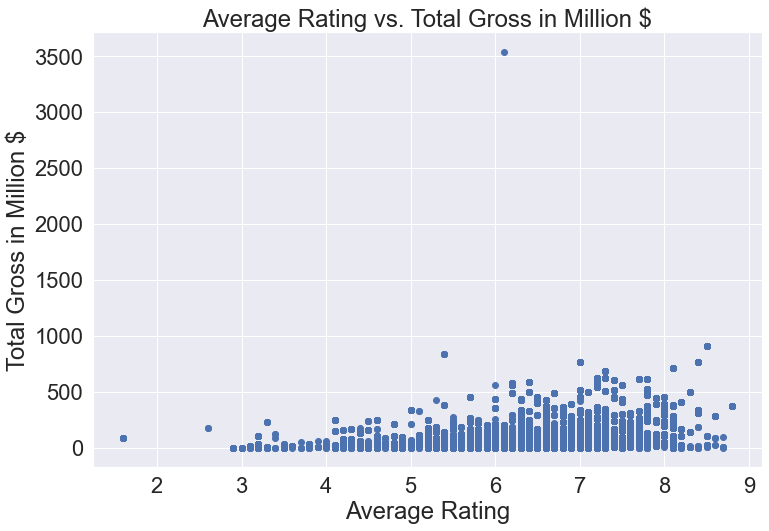

In [102]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(movie_genres_budget["avg_rating"], 
           movie_genres_budget["tot_gross_per_genre_mil"])
ax.set_title("Average Rating vs. Total Gross in Million $")
ax.set_xlabel("Average Rating")
ax.set_ylabel("Total Gross in Million $")
sns.set(font_scale=1)
fig.show()

Group by genres and sum the total gross per genre.

In [103]:
genres_summ = movie_genres_budget.groupby(['genres_sep']).agg({
                                            'num_votes': ['mean', 'median'],
                                            'avg_rating': ['mean', 'median'],
                                            'tot_gross_per_genre_mil': ['mean', 'median']})
genres_summ

num_votes                                avg_rating  \
                            mean               median                 mean   
genres_sep                                                                   
Action                220,773.01           146,401.00                 6.43   
Adventure             231,054.06           140,148.00                 6.55   
Animation             138,620.43            76,108.00                 6.76   
Biography             135,404.77            60,810.50                 7.07   
Comedy                116,922.37            71,361.00                 6.40   
Crime                 131,482.54            81,656.00                 6.46   
Documentary            11,678.44             2,925.00                 7.11   
Drama                 118,631.95            65,571.00                 6.67   
Family                117,107.37            57,549.00                 6.22   
Fantasy               185,889.85           121,936.00                 6.17   
History               113,431.10            59,477.00                 7.06   
Horror                 92,699.06            65,754.00                 5.83   
Music                 107,811.32            51,295.00                 6.53   
Musical               146,545.75           199,663.00                 6.80   
Mystery               146,542.31            84,753.00                 6.33   
N/A                        21.00                22.00                 5.07   
News                       31.00                31.00                 7.00   
Romance                91,872.56            60,510.00                 6.43   
Sci-Fi                339,019.64           234,616.00                 6.69   
Sport                 106,915.51            54,080.00                 6.87   
Thriller              148,715.83            85,010.50                 6.27   
War                    74,786.48            13,089.00                 6.80   
Western               326,043.56           168,514.00                 6.96   

                                 tot_gross_per_genre_mil                       
                          median                    mean               median  
genres_sep                                                                     
Action                      6.50                  136.71                74.66  
Adventure                   6.60                  180.80               126.76  
Animation                   6.80                  182.50               152.29  
Biography                   7.10                   50.87                25.22  
Comedy                      6.40                  100.49                60.34  
Crime                       6.50                   49.34                27.57  
Documentary                 7.30                   38.68                13.01  
Drama                       6.70                   51.78                27.02  
Family                      6.40                  128.69                83.46  
Fantasy                     6.30                  152.17                77.96  
History                     7.10                   44.89                25.61  
Horror                      5.90                   61.43                36.42  
Music                       6.40                   64.13                29.01  
Musical                     7.20                  233.78               187.00  
Mystery                     6.30                   53.09                34.68  
N/A                         5.50                  163.96               157.59  
News                        7.00                   17.82                17.82  
Romance                     6.40                   52.22                29.08  
Sci-Fi                      6.70                  182.09               117.14  
Sport                       7.10                   75.10                33.20  
Thriller                    6.40                   78.01                36.06  
War                         7.05                   34.03                 8

Make the table above into an analyzable format

In [104]:
genres_summ.columns = genres_summ.columns.get_level_values(0) + "_" \
                    + genres_summ.columns.get_level_values(1)
genres_summ.reset_index(inplace=True)
genres_summ

,genres_sep,num_votes_mean,num_votes_median,avg_rating_mean,avg_rating_median,tot_gross_per_genre_mil_mean,tot_gross_per_genre_mil_median
0,Action,"220,773.01","146,401.00",6.43,6.50,136.71,74.66
1,Adventure,"231,054.06","140,148.00",6.55,6.60,180.80,126.76
2,Animation,"138,620.43","76,108.00",6.76,6.80,182.50,152.29
3,Biography,"135,404.77","60,810.50",7.07,7.10,50.87,25.22
4,Comedy,"116,922.37","71,361.00",6.40,6.40,100.49,60.34
5,Crime,"131,482.54","81,656.00",6.46,6.50,49.34,27.57
6,Documentary,"11,678.44","2,925.00",7.11,7.30,38.68,13.01
7,Drama,"118,631.95","65,571.00",6.67,6.70,51.78,27.02
8,Family,"117,107.37","57,549.00",6.22,6.40,128.69,83.46
9,Fantasy,"185,889.85","121,936.00",6.17,6.30,152.17,77.96


<ipython-input-105-f8d7743481d7>:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


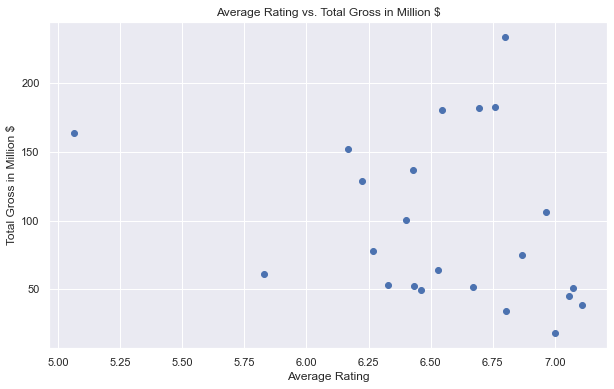

In [105]:
fig, ax = plt.subplots(figsize=(10,6))

ax.scatter(genres_summ["avg_rating_mean"], genres_summ["tot_gross_per_genre_mil_mean"])
ax.set_title("Average Rating vs. Total Gross in Million $")
ax.set_xlabel("Average Rating")
ax.set_ylabel("Total Gross in Million $")
sns.set(font_scale=1)
fig.show()

Distribution plot of average ratings

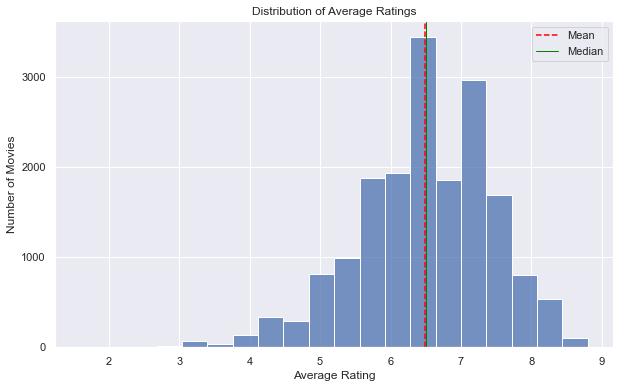

In [106]:
fig, ax = plt.subplots(figsize=(10,6))

sns.histplot(movie_genres_budget['avg_rating'], 
             ax=ax, bins=20).set(title="Distribution of Average Ratings",
                                xlabel="Average Rating", ylabel="Number of Movies");

plt.axvline(x=movie_genres_budget['avg_rating'].mean(),
            color='red',
            ls='--', 
            lw=1.5,
           label="Mean")
plt.axvline(x=movie_genres_budget['avg_rating'].median(),
            color='green',
            ls='-', 
            lw=1,
           label="Median")
plt.legend()
sns.set(font_scale=2)

Bar plot of total profit mean by all genres

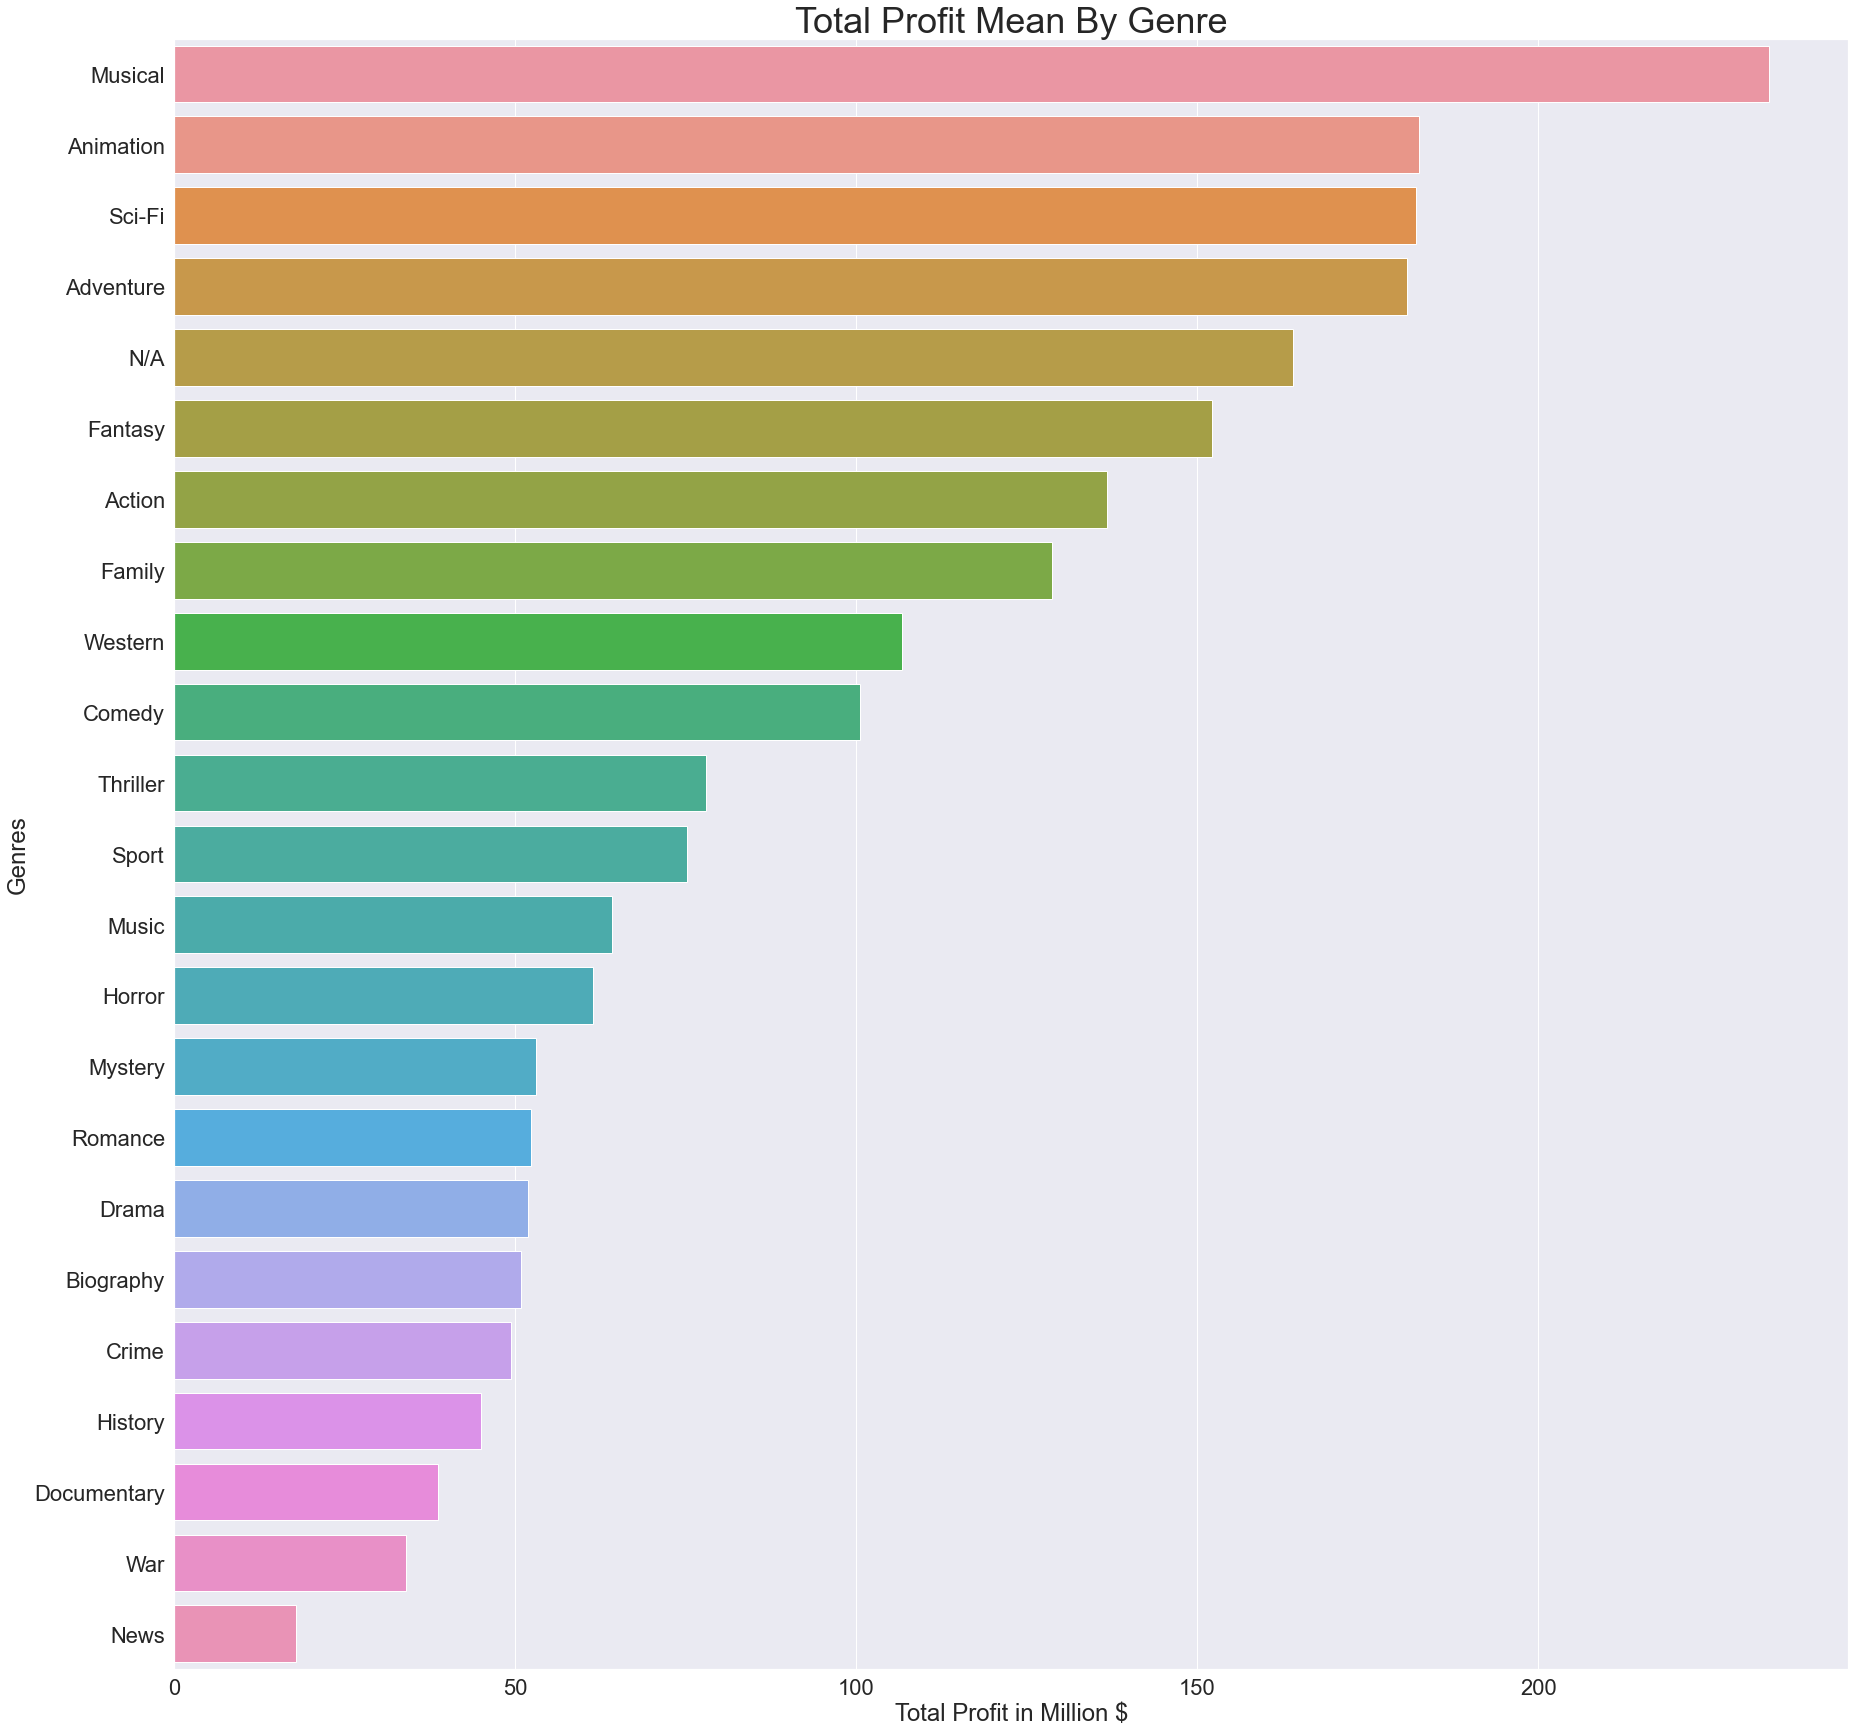

In [107]:
fig, ax = plt.subplots(figsize=(30,30))

genre_budget_sorted = genres_summ.sort_values(by='tot_gross_per_genre_mil_mean', ascending=False)

genre_profit = genre_budget_sorted.tot_gross_per_genre_mil_mean
sns.set(font_scale=3)
sns.barplot(data=genre_budget_sorted, ax=ax, x='tot_gross_per_genre_mil_mean', y='genres_sep',
            order=genres_summ.sort_values(by='tot_gross_per_genre_mil_mean', 
            ascending=False).genres_sep).set(title="Total Profit Mean By Genre",
                                            xlabel='Total Profit in Million $', ylabel='Genres');


Bar plot of total profit median by all genres

[Text(0.5, 1.0, 'Total Profit Median By Genre'),
 Text(0.5, 0, 'Total Profit in Million $'),
 Text(0, 0.5, 'Genres')]

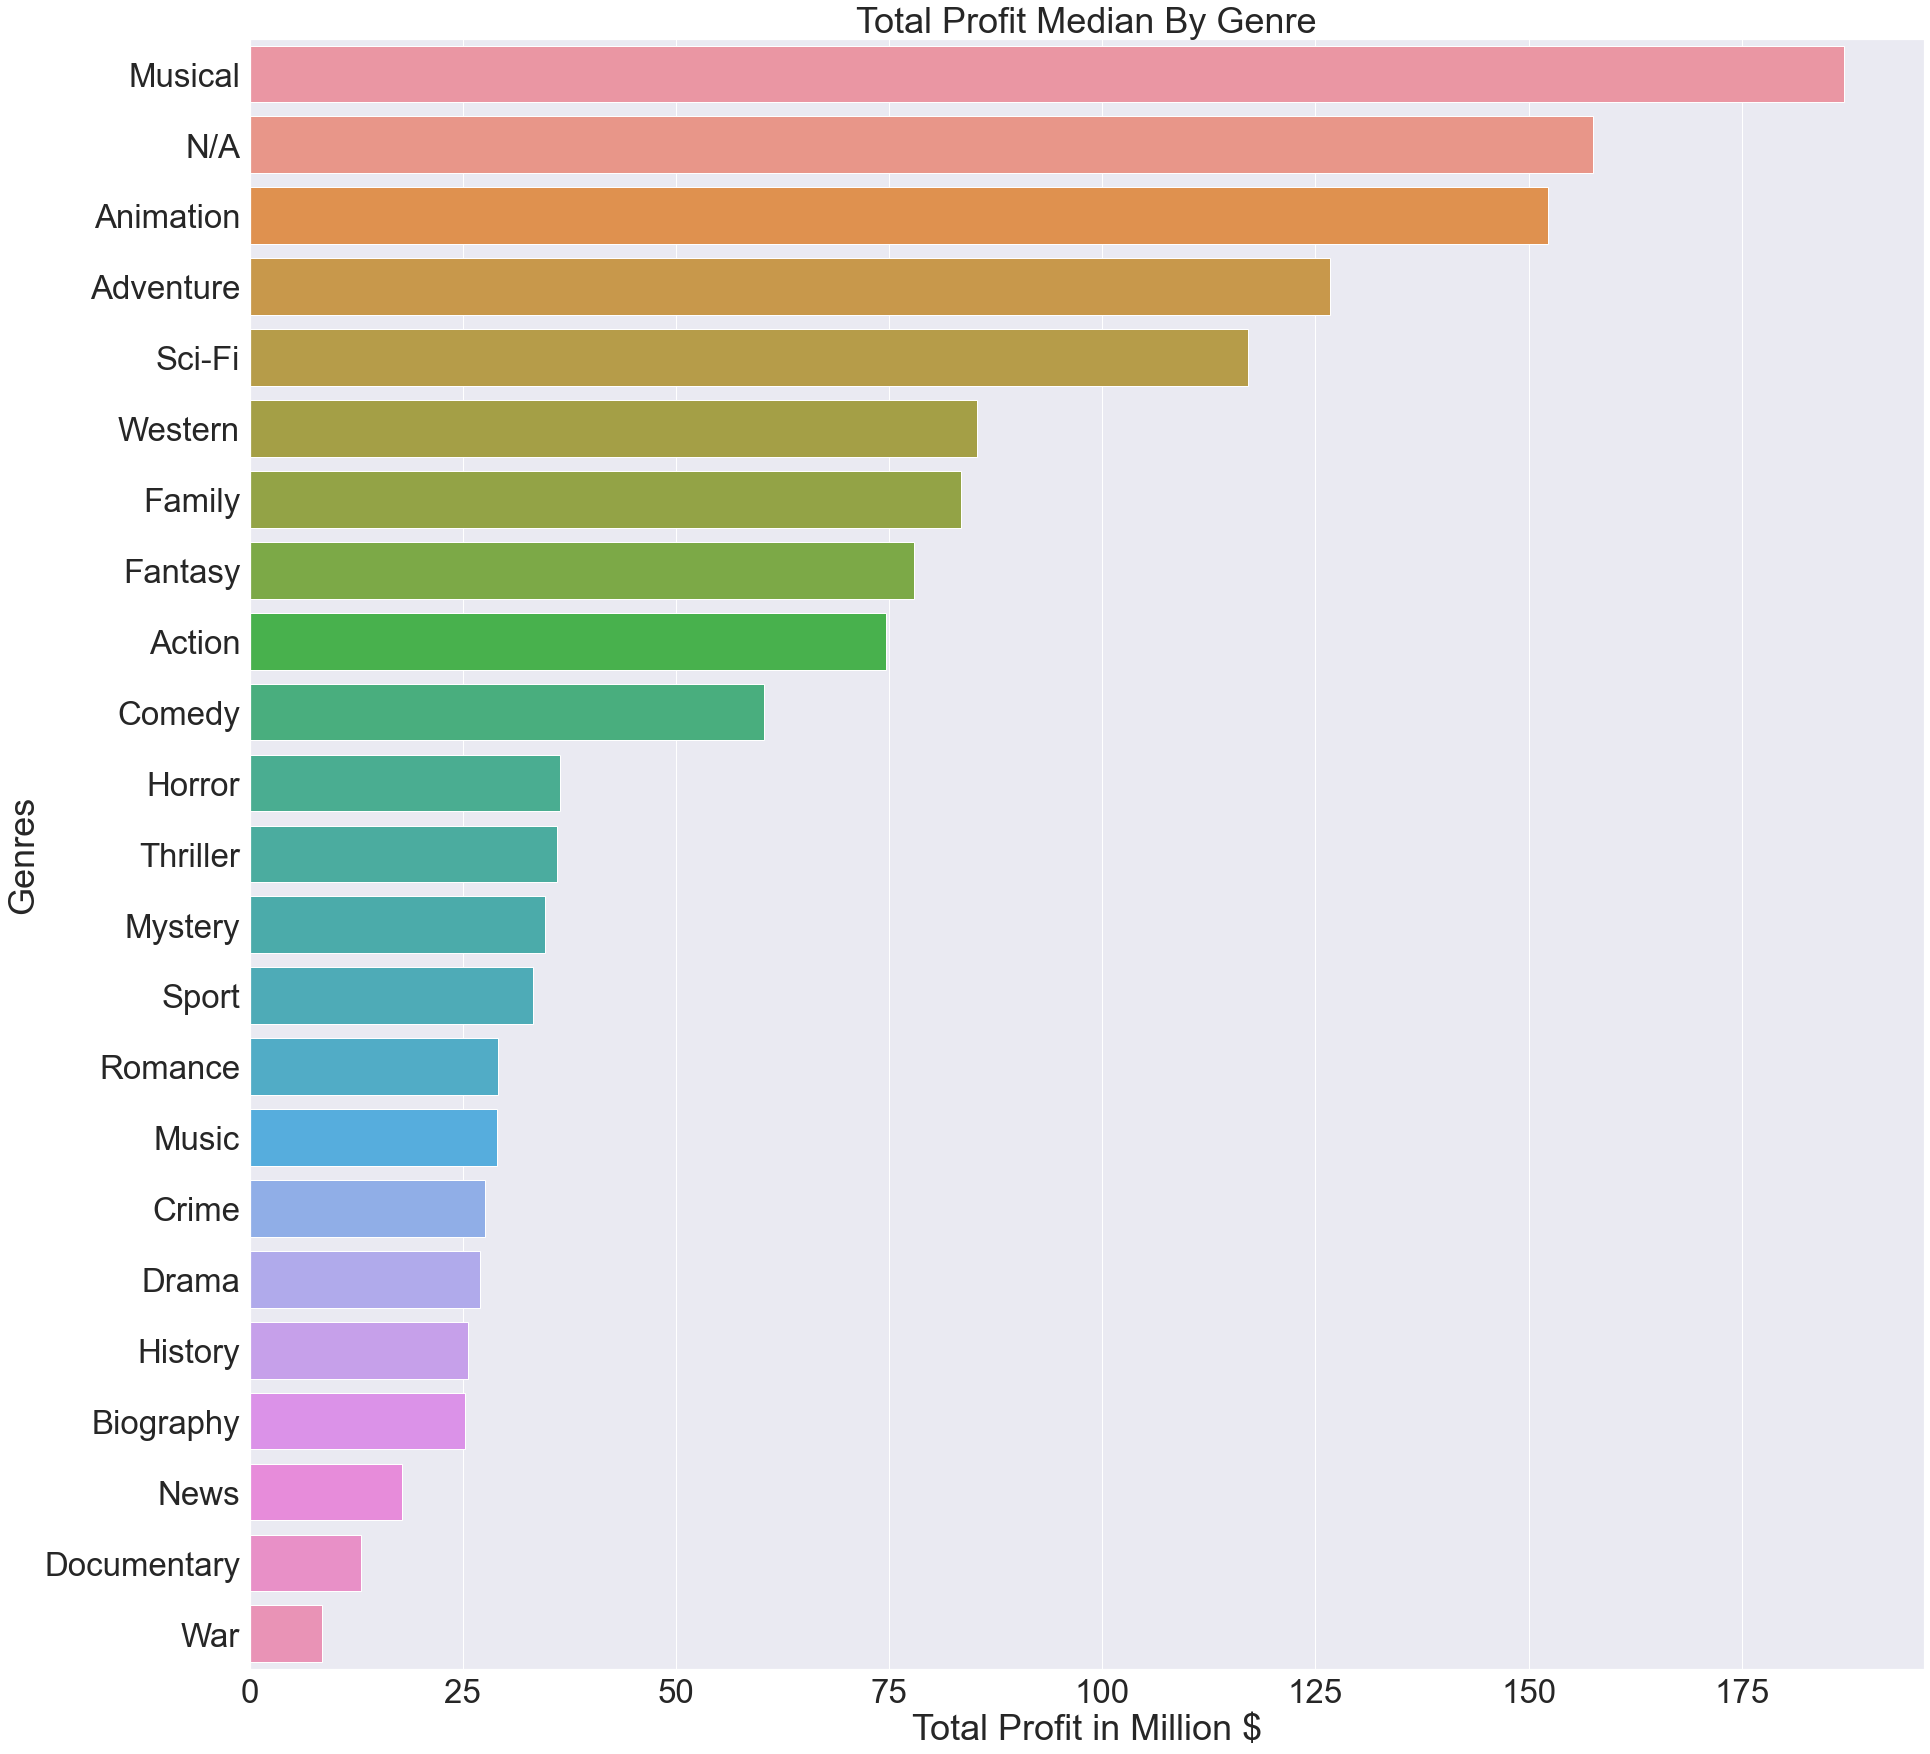

In [108]:
fig, ax = plt.subplots(figsize=(30,30))

genre_budget_sorted = genres_summ.sort_values(by='tot_gross_per_genre_mil_median', ascending=False)

genre_profit = genre_budget_sorted.tot_gross_per_genre_mil_median
sns.set(font_scale=3)
sns.barplot(data=genre_budget_sorted, ax=ax, x='tot_gross_per_genre_mil_median', y='genres_sep',
            order=genres_summ.sort_values(by='tot_gross_per_genre_mil_median', 
            ascending=False).genres_sep).set(title="Total Profit Median By Genre",
                                            xlabel='Total Profit in Million $', ylabel='Genres')

### Hypothesis Testing

Based on the table above, our hypothesis follows below:

- Null: movie genres with a rating less than 6.5 do not impact total gross
- Alternative: movie genres with a rating greater than or equal to 6.5 have a higher total gross

We are considering 95% confidence interval, thus alpha (1 - confidence level) = 0.05

Based on the table above, our hypothesis follows below:

- Null: movie genres with a rating less than 6.5 do not impact total gross
- Alternative: movie genres with a rating greater than or equal to 6.5 have a higher total gross

Separate the total population based on the rating for two-sample z-test

In [109]:
pop_1 = movie_genres_budget[(movie_genres_budget['avg_rating'] <= 6.5) &
                           (movie_genres_budget['tot_gross_per_genre_mil'] > 50)]
pop_2 = movie_genres_budget[(movie_genres_budget['avg_rating'] > 6.5) &
                           (movie_genres_budget['tot_gross_per_genre_mil'] > 50)]

# take random 4000 samples from the total population
sample_1 = pop_1.sample(n=3500, random_state=1)
sample_2 = pop_2.sample(n=3500, random_state=1)

alpha = 0.05

Distribution of Total Gross with Movie Ratings <= 6.5 and Distribution of Total Gross with Movie Ratings > 6.5

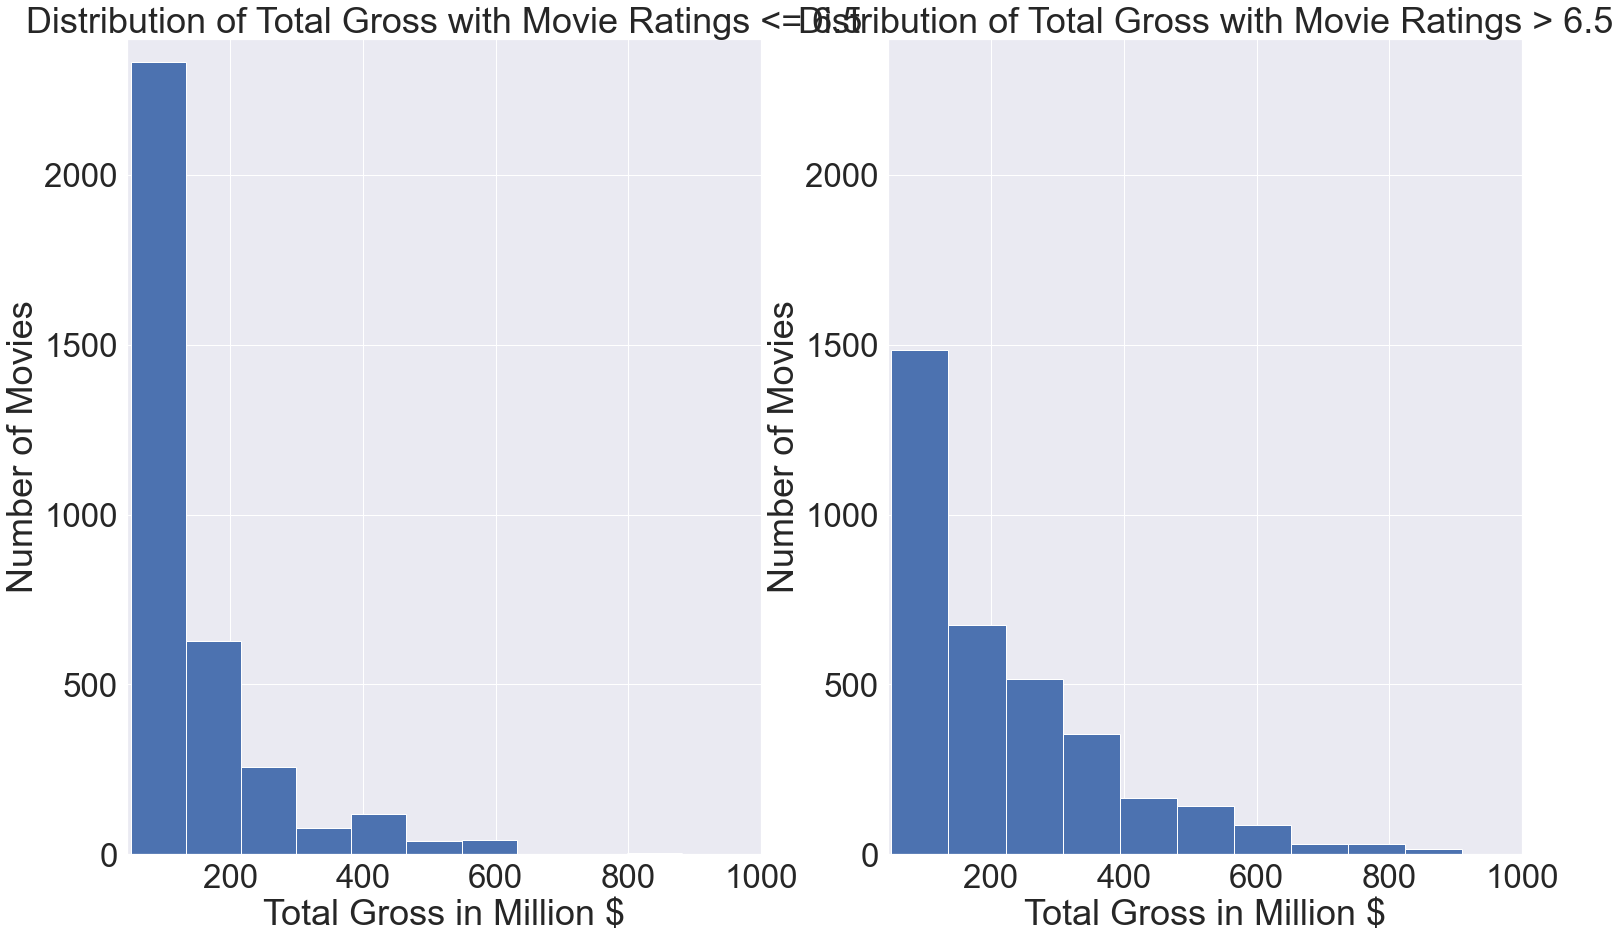

In [110]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(25, 15))

ax1.set_title('Distribution of Total Gross with Movie Ratings <= 6.5')
ax1.set_xlabel('Total Gross in Million $')
ax1.set_ylabel('Number of Movies')
ax1.hist(sample_1['tot_gross_per_genre_mil'], bins=42)
ax1.set_xlim([45, 1000])
ax1.set_ylim([0, 2400])

ax2.set_title('Distribution of Total Gross with Movie Ratings > 6.5')
ax2.set_xlabel('Total Gross in Million $')
ax2.set_ylabel('Number of Movies')
ax2.hist(sample_2['tot_gross_per_genre_mil'])
ax2.set_xlim([45, 1000])
ax2.set_ylim([0, 2400])
plt.show()

In [111]:
genres_high_avg = genres_summ[genres_summ.avg_rating_mean > 6.5]
genres_high_avg

,genres_sep,num_votes_mean,num_votes_median,avg_rating_mean,avg_rating_median,tot_gross_per_genre_mil_mean,tot_gross_per_genre_mil_median
1,Adventure,"231,054.06","140,148.00",6.55,6.60,180.80,126.76
2,Animation,"138,620.43","76,108.00",6.76,6.80,182.50,152.29
3,Biography,"135,404.77","60,810.50",7.07,7.10,50.87,25.22
6,Documentary,"11,678.44","2,925.00",7.11,7.30,38.68,13.01
7,Drama,"118,631.95","65,571.00",6.67,6.70,51.78,27.02
10,History,"113,431.10","59,477.00",7.06,7.10,44.89,25.61
12,Music,"107,811.32","51,295.00",6.53,6.40,64.13,29.01
13,Musical,"146,545.75","199,663.00",6.80,7.20,233.78,187.00
16,News,31.00,31.00,7.00,7.00,17.82,17.82
18,Sci-Fi,"339,019.64","234,616.00",6.69,6.70,182.09,117.14


Total profit by genere with ratings > 6.5

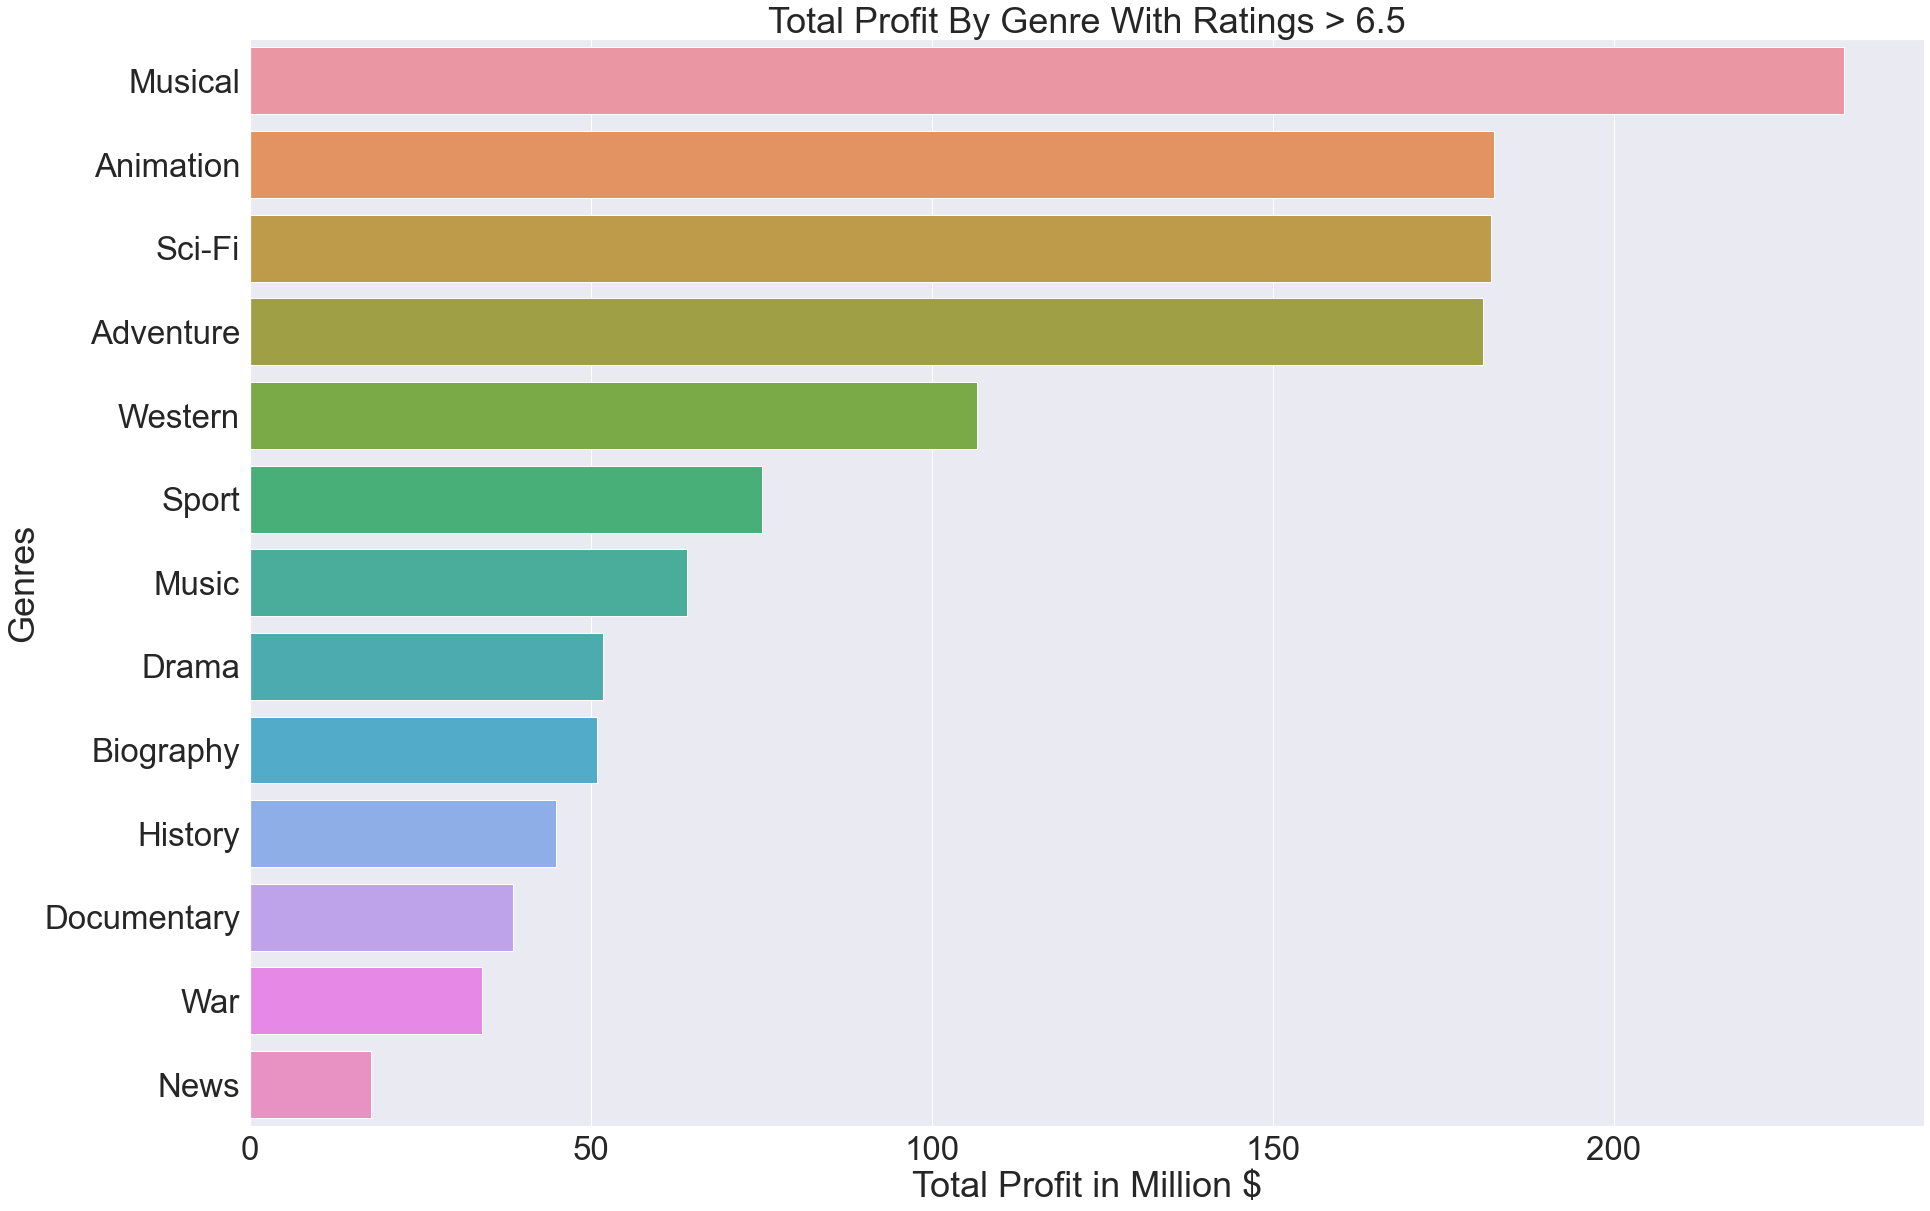

In [112]:
fig, ax = plt.subplots(figsize=(30,20))

genres_high_avg_sorted = genres_high_avg.sort_values(by='tot_gross_per_genre_mil_mean', 
                                                     ascending=False)
sns.set(font_scale=3)
sns.barplot(data=genres_high_avg_sorted, ax=ax, x='tot_gross_per_genre_mil_mean', y='genres_sep',
            order=genres_high_avg_sorted.sort_values(by='tot_gross_per_genre_mil_mean', 
            ascending=False).genres_sep).set(title="Total Profit By Genre With Ratings > 6.5",
            xlabel='Total Profit in Million $', ylabel='Genres');

Total Profit By Genre With Ratings > 6.5 & Number of Votes > 135000

In [113]:
genres_high_avg2 = genres_summ[(genres_summ.avg_rating_mean > 6.5) & (genres_summ.num_votes_mean > 135000)]
genres_high_avg2

,genres_sep,num_votes_mean,num_votes_median,avg_rating_mean,avg_rating_median,tot_gross_per_genre_mil_mean,tot_gross_per_genre_mil_median
1,Adventure,"231,054.06","140,148.00",6.55,6.60,180.80,126.76
2,Animation,"138,620.43","76,108.00",6.76,6.80,182.50,152.29
3,Biography,"135,404.77","60,810.50",7.07,7.10,50.87,25.22
13,Musical,"146,545.75","199,663.00",6.80,7.20,233.78,187.00
18,Sci-Fi,"339,019.64","234,616.00",6.69,6.70,182.09,117.14
22,Western,"326,043.56","168,514.00",6.96,6.60,106.62,85.32


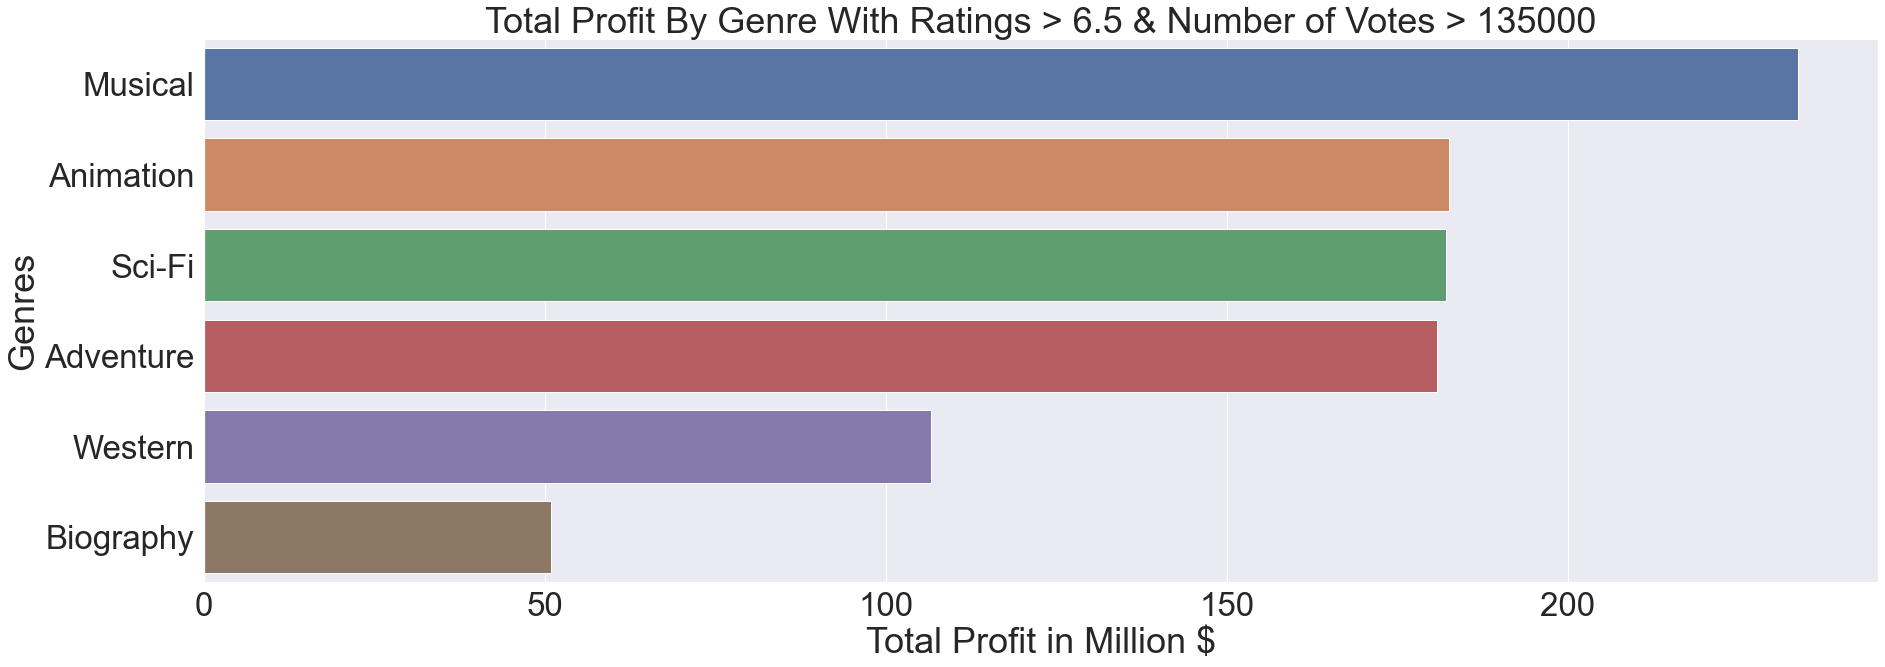

In [114]:
fig, ax = plt.subplots(figsize=(30,10))

genres_high_avg2_sorted = genres_high_avg2.sort_values(by='tot_gross_per_genre_mil_mean', 
                                                     ascending=False)
sns.set(font_scale=3)
sns.barplot(data=genres_high_avg2_sorted, ax=ax, x='tot_gross_per_genre_mil_mean', y='genres_sep',
            order=genres_high_avg2_sorted.sort_values(by='tot_gross_per_genre_mil_mean', 
            ascending=False).genres_sep).set(title="Total Profit By Genre With Ratings > 6.5 & Number of Votes > 135000",
            xlabel='Total Profit in Million $', ylabel='Genres');

Source for two-sample z-test:
https://www.statsmodels.org/dev/generated/statsmodels.stats.weightstats.ztest.html

In [115]:
# calculate p-values and z-score
from statsmodels.stats.weightstats import ztest as ztest

ztest(sample_1['tot_gross_per_genre_mil'],sample_2['tot_gross_per_genre_mil'])

print("z-score for our two sample test = ", abs(ztest(sample_1['tot_gross_per_genre_mil'],
                                                  sample_2['tot_gross_per_genre_mil'])[0]))
print("p-value for our two sample test = ", ztest(sample_1['tot_gross_per_genre_mil'],
                                                  sample_2['tot_gross_per_genre_mil'])[1])

z-score for our two sample test =  22.379145668204956
p-value for our two sample test =  6.283688768094047e-111


Since p-value 4.8e-112 is less than alpha = 0.05 and z-score is 22.49 which is greater than confidence level (0.95), **we conclude that we reject the null hypothesis and say that movie genres with a rating greater than or equal to 6.5 have a higher total gross**.

**In conclusion, we recommend Computer Vision to focus on the movies with ratings higher than 6.5 and Musical, Animation, Sci-Fi, and Adventure genres!**

## Results

* Advantages: 
     * Avoid common pitfalls through intelligent investment
     * Greatly improve return on investment potential
     * Reduce losses

* Limitations:
    * Lack pricing for directors
    * Return on investment is easily skewed
    * Limited data for some countries

## Conclusion

* Invest in top genres
* Release in areas with top languages.
* Research pricing for directors.
* Continue researching trends.

## Next Steps
* Gather more data on customer interest. (i.e. surveys)
* Research the top languages per region.
* Continually analyze trends using current datasets.